# Data Preparation

In [25]:
# Used data from Kaggle - https://www.kaggle.com/c/dogs-vs-cats/data
# Tried to work with color photos but found it to be cumbersome during loading and training - more for a server implementation

# import standard packages here
# non standard packages are imported closer to the code/functions that use them
import warnings
warnings.filterwarnings("ignore")

# import data manipulation/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for model building and results
import tensorflow as tf

# for reading in pictures
import cv2
from tqdm import tqdm
import os

# misc
import time
from prettytable import PrettyTable

# fix a random seed for reproducibility
RANDOM_SEED = 42
from numpy.random import seed
from tensorflow import set_random_seed
def reset_graph(seed = RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [ ]:
# global params
# define color palette
current_palette = sns.color_palette() #10 colors

# set file paths
main_dir = os.getcwd()
train_dir = "dogs-vs-cats/train"
train_path = os.path.join(main_dir,train_dir)

# set model path for saving output
model_path = '..\\output\\models'

# set pixel height and width for images
height = 96
width = 96

In [2]:
# https://www.kaggle.com/shrawansapre/dogs-vs-cats-convolutional-neural-nets
label=[]
data=[]

# Loop iterating over each file in the training folder
for file in tqdm(os.listdir(train_path)):
    # Reading every image and converting it to grayscale
    image = cv2.imread(os.path.join(train_path,file), cv2.IMREAD_GRAYSCALE)
    # Resizing the image into a manageable size
    image = cv2.resize(image,(height,width))
    # If a file name starts with "cat"
    # Then label it as class 0
    if file.startswith("cat"):
        label.append(0)
    elif file.startswith("dog"):
        label.append(1)
    try:
        data.append(image/255) 
    except:
        label=label[:len(label)-1]

100%|██████████| 25000/25000 [01:25<00:00, 254.23it/s]


In [3]:
# Converting our data and labels into numpy arrays
X = np.array(data)
y = np.array(label)

print(X.shape)
print(y.shape)

(25000, 96, 96)
(25000,)


In [4]:
# doing this to save memory since running this locally
del data
import gc # Garbage Collector
gc.collect()

7

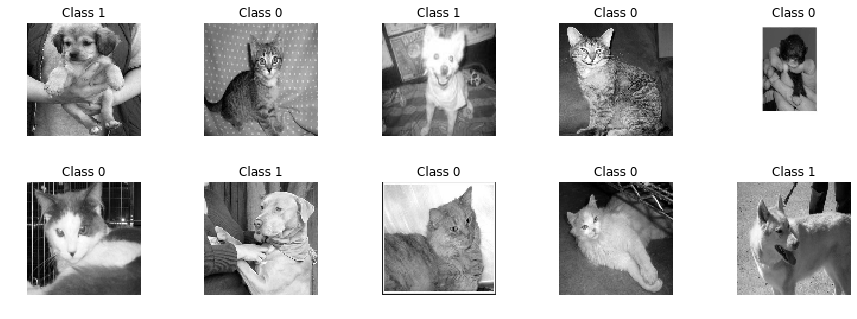

In [5]:
# Displaying the first 10 images along with the class it belongs to
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for index in range(0,10):
    plt.subplot(2, 5, index + 1)
    plt.imshow(X[index], cmap='gray')
    plt.title('Class '+ str(y[index]))
    plt.axis('off')

In [6]:
# Reshaping our data from a 96x96 array into a 96,96,1 array
channel = 1 # b/c we are working with b&w images
X = X.reshape((X.shape)[0],(X.shape)[1],(X.shape)[2],channel)
print(X.shape)
print(y.shape)

(25000, 96, 96, 1)
(25000,)


In [28]:
# check min and max values to make sure values are between 0 and 1
print("Max value is: ", np.amax(X))
print("Min value is: ", np.amin(X))

Max value is:  1.0
Min value is:  0.0


Text(0.5, 1.0, 'Dogs and Cats by Label')

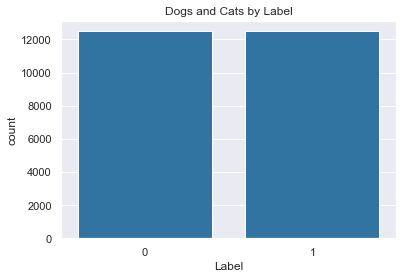

In [29]:
# how many of each class are we dealing with?
labels_df = pd.DataFrame({'Label':label})

current_palette = sns.color_palette() #10 colors
sns.set(style="darkgrid")
sns.countplot(x='Label', data=labels_df, color=current_palette[0]).set_title("Dogs and Cats by Label") 

In [7]:
# need to reduce the size of the data set to help speed training since running this locally
# and then split out into training, validation, and test sets
# first, let's reduce the overall size of the data set to 5000 images
from sklearn.model_selection import train_test_split
X_model, X_remaining, y_model, y_remaining = train_test_split(X, y, train_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

In [31]:
# quick check shape of initial split - expecting to see 5K images
print(X_model.shape)
print(y_model.shape)

# verify number of cats and dogs
num_zeros = (y_model == 0).sum()
num_ones = (y_model == 1).sum()
print("The number of cats is: ", num_zeros)
print("The number of dogs is: ", num_ones)

(5000, 96, 96, 1)
(5000,)
The number of cats is:  2500
The number of dogs is:  2500


In [8]:
gc.collect()

40

In [9]:
# now we can split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y_model)

# we will also split into training and validation sets for model building - we have a 60/20/20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_SEED, shuffle=True, stratify=y_train)

In [34]:
# verify the train and test splits
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape:  (3000, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
X_test shape:  (1000, 96, 96, 1)
y_train shape:  (3000,)
y_val shape:  (1000,)
y_test shape: (1000,)


In [ ]:
gc.collect()

In [10]:
# need to do some extra preparation to run this data through a dense network for comparison
X_train_dense = X_train.reshape(-1,width*height)
X_val_dense = X_val.reshape(-1,width*height)
X_test_dense = X_test.reshape(-1,width*height)
y_train_dense = y_train.reshape(-1, 1) # have to do this; otherwise get errors during model building
y_val_dense = y_val.reshape(-1, 1)
y_test_dense = y_test.reshape(-1, 1)

In [37]:
#X_train_dense = X_train.reshape(X_train[0],-1)
print("X_train shape: ", X_train_dense.shape)
print("X_val shape: ", X_val_dense.shape)
print("X_test shape: ", X_test_dense.shape)
print("y_train shape: ", y_train_dense.shape)
print("y_val shape: ", y_val_dense.shape)
print("y_test shape: ", y_test_dense.shape)

X_train shape:  (3000, 9216)
X_val shape:  (1000, 9216)
X_test shape:  (1000, 9216)
y_train shape:  (3000, 1)
y_val shape:  (1000, 1)
y_test shape:  (1000, 1)


In [38]:
y_train_vectorize = np.asarray(y_train).astype('float32')
y_val_vectorize = np.asarray(y_val).astype('float32')
y_test_vectorize = np.asarray(y_test).astype('float32')

# Methods

In [11]:
# global params for modeling
# height and width were defined at the top
n_inputs = height * width 
channel = 1
n_outputs = 1
n_batch_size = 512
num_epochs = 50

In [ ]:
# change directory to model folder so we can save models
os.chdir(model_path)

In [12]:
# was getting some weird placeholder or graph errors that were resolved by running the below
import keras.backend as K
K.clear_session()

Using TensorFlow backend.


In [13]:
# dense model functions
# accuracy is OK to use here since classes are balanced
# using rmsprop default learning rate
from keras import layers, models, optimizers

def dense_model_double(nodes1, nodes2):
    model = models.Sequential()
    model.add(layers.Dense(nodes1, activation='relu', input_shape=(n_inputs,))) 
    model.add(layers.Dense(nodes2, activation='relu')) 
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot the training and validation loss
def loss_plot(history, model_name):
    # define the values for the plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    # now plot these values
    plt.plot(epochs, loss, color=current_palette[0], label='Training loss')
    plt.plot(epochs, val_loss, color=current_palette[1], label='Validation loss')
    plt.title('Training and validation loss ' + str(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.show()
    
# plot the training and validation accuracy
def acc_plot(history, model_name):
    # define the values for the plot
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1,len(acc)+1)
    # now plot these values
    plt.plot(epochs, acc, color=current_palette[0], label = 'Training acc')
    plt.plot(epochs, val_acc, color=current_palette[1], label='Validation acc')
    plt.title('Training and validation accuracy ' + str(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.show()    

def dense_model_generation(model_name, nodes1, nodes2):
    #reset_graph() # keep results consistent
    # builds the model that was defined above
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = dense_model_double(nodes1,nodes2)
    history = model.fit(X_train_dense, y_train, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val_dense, y_val), verbose=0)
    summary = model.summary()
    weights = model.get_weights()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
    plt.figure(1)
    plt.subplot(121)
    loss_plot(history, model_name)
    plt.subplot(122)
    acc_plot(history, model_name)
    plt.show()
    return summary, weights, history

In [34]:
# CNN model functions
# make sure to save model!
def cnn_two_layers():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    return model
    
def cnn_three_layers():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    return model

def cnn_four_layers():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    return model

def cnn_model_generation(model, model_name):
    #reset_graph() # keep results consistent
    # builds the model that was defined above
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    history = model.fit(X_train, y_train, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val, y_val), verbose=0)
    model.save(str(model_name+'.h5'))
    summary = model.summary()
    weights = model.get_weights()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
    plt.figure(1)
    plt.subplot(121)
    loss_plot(history, model_name)
    plt.subplot(122)
    acc_plot(history, model_name)
    plt.show()
    return summary, weights, history

from keras.preprocessing.image import ImageDataGenerator

def cnn_model_generation_data_aug(model, model_name):
    #reset_graph() # keep results consistent
    # builds the model that was defined above
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,)
    datagen.fit(X_train)
    history = model.fit(X_train, y_train, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val, y_val), verbose=0)
    model.save(str(model_name+'.h5'))
    summary = model.summary()
    weights = model.get_weights()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
    plt.figure(1)
    plt.subplot(121)
    loss_plot(history, model_name)
    plt.subplot(122)
    acc_plot(history, model_name)
    plt.show()
    return summary, weights, history

## DNN

In [45]:
# running this to save space
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 18434     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 18,443
Trainable params: 18,443
Non-trainable params: 0
_________________________________________________________________


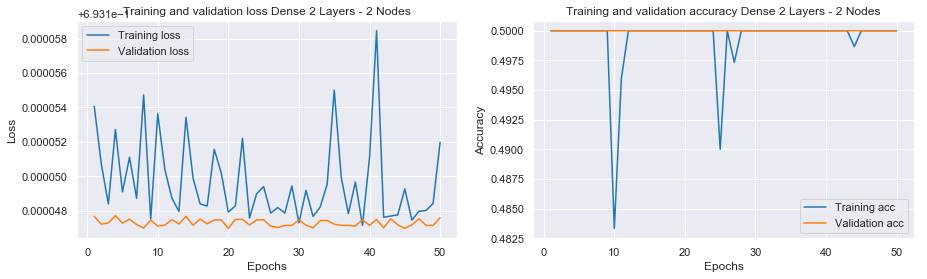

In [46]:
dense_two_layers_2_nodes_start_time = time.time()
dense_two_layers_2_nodes = dense_model_generation("Dense 2 Layers - 2 Nodes",2,2)
dense_two_layers_2_nodes_elapsed_time = time.time() - dense_two_layers_2_nodes_start_time

In [47]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                147472    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 147,761
Trainable params: 147,761
Non-trainable params: 0
_________________________________________________________________


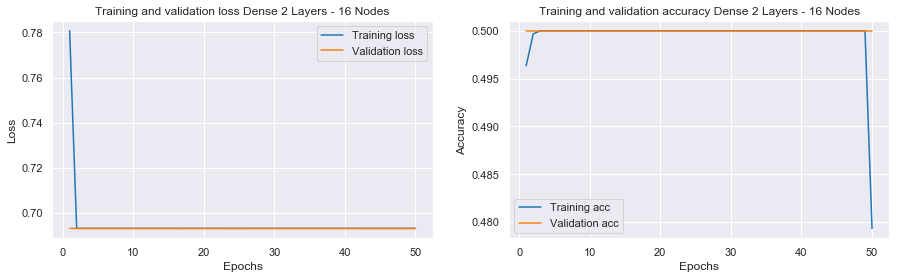

In [48]:
dense_two_layers_16_nodes_start_time = time.time()
dense_two_layers_16_nodes = dense_model_generation("Dense 2 Layers - 16 Nodes",16,16)
dense_two_layers_16_nodes_elapsed_time = time.time() - dense_two_layers_16_nodes_start_time

In [49]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                589888    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 594,113
Trainable params: 594,113
Non-trainable params: 0
_________________________________________________________________


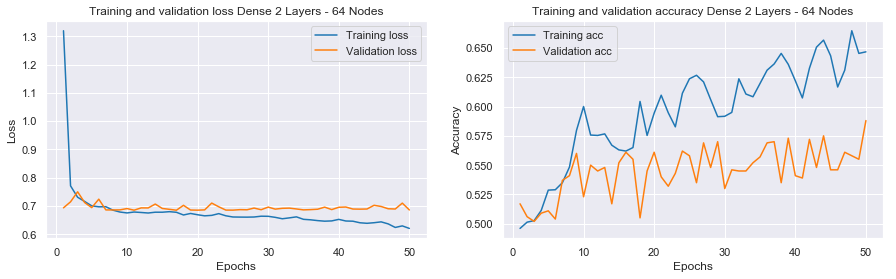

In [50]:
dense_two_layers_64_nodes_start_time = time.time()
dense_two_layers_64_nodes = dense_model_generation("Dense 2 Layers - 64 Nodes",64,64)
dense_two_layers_64_nodes_elapsed_time = time.time() - dense_two_layers_64_nodes_start_time

In [51]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 931,901
Trainable params: 931,901
Non-trainable params: 0
_________________________________________________________________


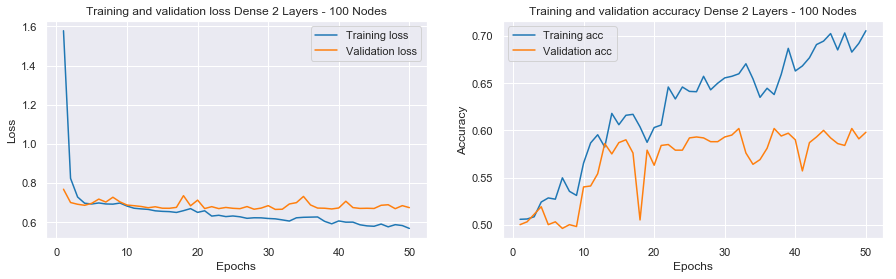

In [52]:
dense_two_layers_100_nodes_start_time = time.time()
dense_two_layers_100_nodes = dense_model_generation("Dense 2 Layers - 100 Nodes",100,100)
dense_two_layers_100_nodes_elapsed_time = time.time() - dense_two_layers_100_nodes_start_time

In [53]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               2765100   
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 2,855,701
Trainable params: 2,855,701
Non-trainable params: 0
_________________________________________________________________


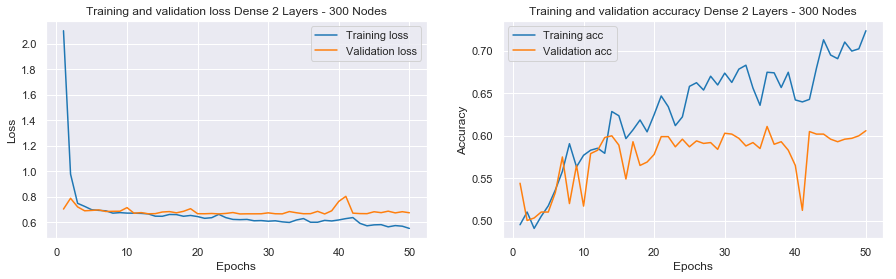

In [54]:
dense_two_layers_300_nodes_start_time = time.time()
dense_two_layers_300_nodes = dense_model_generation("Dense 2 Layers - 300 Nodes",300,300)
dense_two_layers_300_nodes_elapsed_time = time.time() - dense_two_layers_300_nodes_start_time

In [55]:
# generate table to summarize results
# this is a little gross but functions at least make it easy to add rows
m1_acc = '{:.1%}'.format(np.mean(dense_two_layers_2_nodes[2].history['acc']))
m1_val_acc = '{:.1%}'.format(np.mean(dense_two_layers_2_nodes[2].history['val_acc']))
m2_acc = '{:.1%}'.format(np.mean(dense_two_layers_16_nodes[2].history['acc']))
m2_val_acc = '{:.1%}'.format(np.mean(dense_two_layers_16_nodes[2].history['val_acc']))
m3_acc = '{:.1%}'.format(np.mean(dense_two_layers_64_nodes[2].history['acc']))
m3_val_acc = '{:.1%}'.format(np.mean(dense_two_layers_64_nodes[2].history['val_acc']))
m4_acc = '{:.1%}'.format(np.mean(dense_two_layers_100_nodes[2].history['acc']))
m4_val_acc = '{:.1%}'.format(np.mean(dense_two_layers_100_nodes[2].history['val_acc']))
m5_acc = '{:.1%}'.format(np.mean(dense_two_layers_300_nodes[2].history['acc']))
m5_val_acc = '{:.1%}'.format(np.mean(dense_two_layers_300_nodes[2].history['val_acc']))

a = PrettyTable()
a.field_names = ['Model', 'Nodes', 'Train Accuracy', 'Val Accuracy', 'Processing Time']
a.add_row(['DNN - M1', '2,2', m1_acc, m1_val_acc, round(dense_two_layers_2_nodes_elapsed_time,1)])
a.add_row(['DNN - M2', '16,16', m2_acc, m2_val_acc, round(dense_two_layers_16_nodes_elapsed_time,1)])
a.add_row(['DNN - M3','64,64', m3_acc, m3_val_acc, round(dense_two_layers_64_nodes_elapsed_time,1)])
a.add_row(['DNN - M4','100,100',m4_acc, m4_val_acc, round(dense_two_layers_100_nodes_elapsed_time,1)])
a.add_row(['DNN - M5','300,300',m5_acc, m5_val_acc, round(dense_two_layers_300_nodes_elapsed_time,1)])
print(a.get_string(title="DNN Training Results"))

+----------------------------------------------------------------------+
|                         DNN Training Results                         |
+----------+---------+----------------+--------------+-----------------+
|  Model   |  Nodes  | Train Accuracy | Val Accuracy | Processing Time |
+----------+---------+----------------+--------------+-----------------+
| DNN - M1 |   2,2   |     49.9%      |    50.0%     |       19.2      |
| DNN - M2 |  16,16  |     50.0%      |    50.0%     |       18.3      |
| DNN - M3 |  64,64  |     59.5%      |    54.5%     |       25.4      |
| DNN - M4 | 100,100 |     62.4%      |    56.7%     |       47.0      |
| DNN - M5 | 300,300 |     62.9%      |    57.7%     |       66.0      |
+----------+---------+----------------+--------------+-----------------+


## CNN

In [35]:
gc.collect()
K.clear_session()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30976)             0         
___________________________

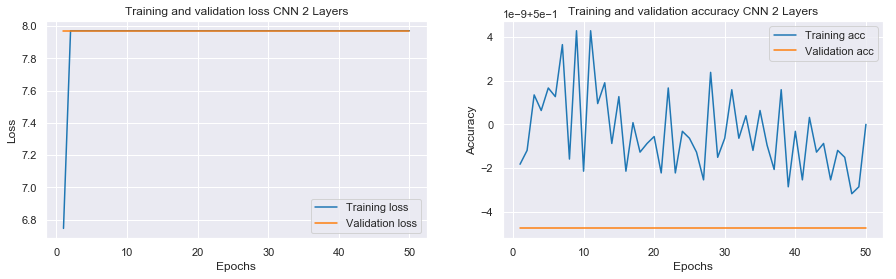

In [36]:
cnn_two_layers_start_time = time.time()
cnn_two_layers = cnn_model_generation(cnn_two_layers(), "CNN 2 Layers")
cnn_two_layers_elapsed_time = time.time() - cnn_two_layers_start_time

In [37]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
__________

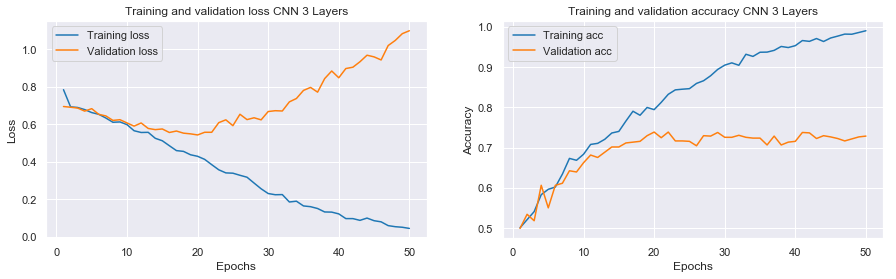

In [38]:
cnn_three_layers_start_time = time.time()
cnn_three_layers = cnn_model_generation(cnn_three_layers(), "CNN 3 Layers")
cnn_three_layers_elapsed_time = time.time() - cnn_three_layers_start_time

In [39]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
__________

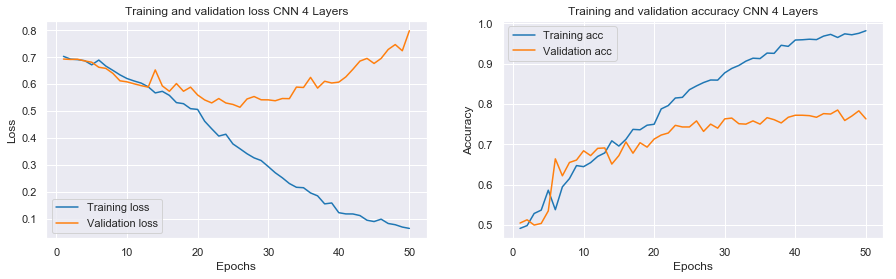

In [40]:
cnn_four_layers_start_time = time.time()
cnn_four_layers = cnn_model_generation(cnn_four_layers(), "CNN 4 Layers")
cnn_four_layers_elapsed_time = time.time() - cnn_four_layers_start_time

In [53]:
# generate table to summarize results
cnn_m1_acc = '{:.1%}'.format(np.mean(cnn_two_layers[2].history['acc']))
cnn_m1_val_acc = '{:.1%}'.format(np.mean(cnn_two_layers[2].history['val_acc']))
cnn_m2_acc = '{:.1%}'.format(np.mean(cnn_three_layers[2].history['acc']))
cnn_m2_val_acc = '{:.1%}'.format(np.mean(cnn_three_layers[2].history['val_acc']))
cnn_m3_acc = '{:.1%}'.format(np.mean(cnn_four_layers[2].history['acc']))
cnn_m3_val_acc = '{:.1%}'.format(np.mean(cnn_four_layers[2].history['val_acc']))

a = PrettyTable()
a.field_names = ['Model', 'Nodes', 'Train Accuracy', 'Val Accuracy', 'Processing Time']
a.add_row(['CNN - M1', '32,64', cnn_m1_acc, cnn_m1_val_acc, round(cnn_two_layers_elapsed_time,1)])
a.add_row(['CNN - M2', '32,64,128', cnn_m2_acc, cnn_m2_val_acc, round(cnn_three_layers_elapsed_time,1)])
a.add_row(['CNN - M3','32,64,128,128', cnn_m3_acc, cnn_m3_val_acc, round(cnn_four_layers_elapsed_time,1)])
print(a.get_string(title="CNN Training Results"))

+--------------------------------------------------------------------+
|                        CNN Training Results                        |
+----------+-------+----------------+--------------+-----------------+
|  Model   | Nodes | Train Accuracy | Val Accuracy | Processing Time |
+----------+-------+----------------+--------------+-----------------+
| CNN - M1 |  2,2  |     50.0%      |    50.0%     |      4489.9     |
| CNN - M2 | 16,16 |     82.5%      |    69.3%     |      4900.1     |
| CNN - M3 | 64,64 |     80.0%      |    70.9%     |      4732.4     |
+----------+-------+----------------+--------------+-----------------+


## Additional CNN Iterations

In [15]:
# increased drop out slightly
# increase LR
# made dense layer have less nodes
def cnn_four_layers3():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.25))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    return model

# larger learning rate
def cnn_four_layers2():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    return model

# larger filter size
# slightly higher dropout
def cnn_four_layers4():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5,5), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (5,5), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (5,5), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (5,5), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.25))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])
    return model

def cnn_four_layers5():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    return model

# no pyramid - just the same layer
def cnn_four_layers6():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    return model

# no pyramid - just the same layer
def cnn_four_layers8():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    return model

# no pyramid - just the same layer
def cnn_four_layers7():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape = (height, width, channel)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.001), metrics=['accuracy'])
    return model

In [16]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
__________

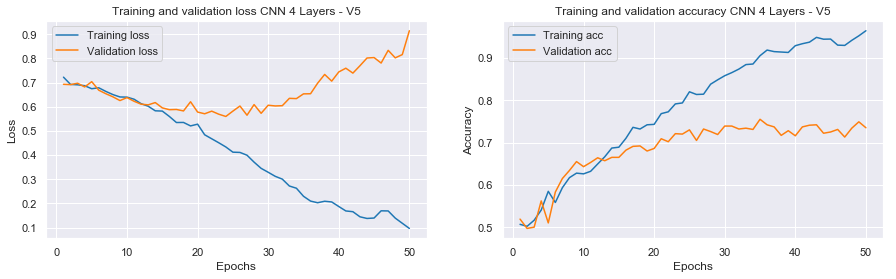

In [136]:
cnn_four_layers_start_time5 = time.time()
cnn_four_layers5 = cnn_model_generation(cnn_four_layers5(), "CNN 4 Layers - V5")
cnn_four_layers_elapsed_time5 = time.time() - cnn_four_layers_start_time5

In [22]:
gc.collect()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
__________

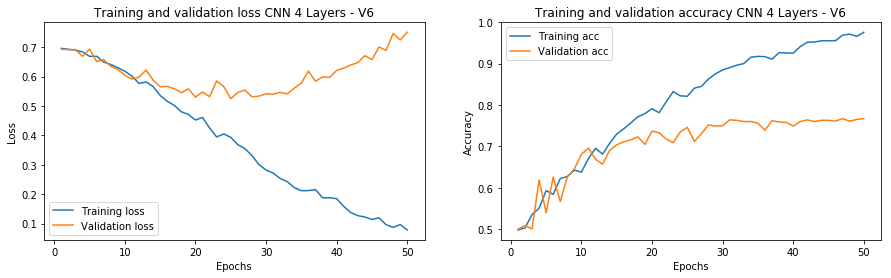

In [23]:
cnn_four_layers_start_time6 = time.time()
cnn_four_layers6 = cnn_model_generation(cnn_four_layers6(), "CNN 4 Layers - V6")
cnn_four_layers_elapsed_time6 = time.time() - cnn_four_layers_start_time6

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         147584    
__________

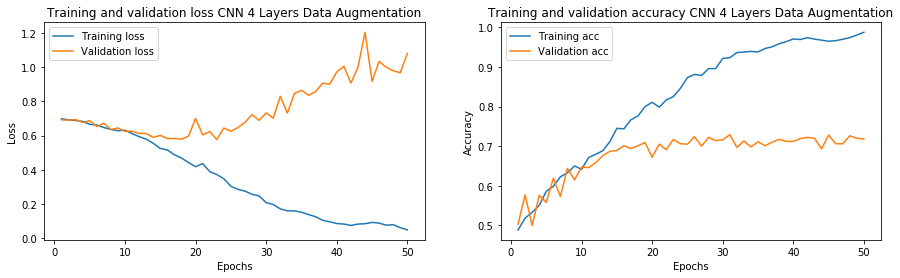

In [35]:
cnn_four_layers_data_aug_start_time = time.time()
cnn_four_layers_data_aug = cnn_model_generation_data_aug(cnn_four_layers(), "CNN 4 Layers Data Augmentation")
cnn_four_layers_data_aug_elapsed_time = time.time() - cnn_four_layers_data_aug_start_time

In [36]:
cnn_m4_acc = '{:.1%}'.format(np.mean(cnn_four_layers6[2].history['acc']))
cnn_m4_val_acc = '{:.1%}'.format(np.mean(cnn_four_layers6[2].history['val_acc']))
cnn_m4_data_aug_acc = '{:.1%}'.format(np.mean(cnn_four_layers_data_aug[2].history['acc']))
cnn_m4_data_aug_val_acc = '{:.1%}'.format(np.mean(cnn_four_layers_data_aug[2].history['val_acc']))

a = PrettyTable()
a.field_names = ['Model', 'Nodes', 'Train Accuracy', 'Val Accuracy', 'Processing Time']
a.add_row(['CNN - M4 V6', '64,64,64,64', cnn_m4_acc, cnn_m4_val_acc, round(cnn_four_layers_elapsed_time6,1)])
a.add_row(['CNN - M4 Data Aug', '32,64,128,128', cnn_m4_data_aug_acc, cnn_m4_data_aug_val_acc, round(cnn_four_layers_data_aug_elapsed_time,1)])
print(a.get_string(title="CNN Training Results"))

+-------------------------------------------------------------------------------------+
|                                 CNN Training Results                                |
+-------------------+---------------+----------------+--------------+-----------------+
|       Model       |     Nodes     | Train Accuracy | Val Accuracy | Processing Time |
+-------------------+---------------+----------------+--------------+-----------------+
|    CNN - M4 V6    |  64,64,64,64  |     80.4%      |    70.7%     |     10112.4     |
| CNN - M4 Data Aug | 32,64,128,128 |     82.1%      |    68.0%     |      3786.6     |
+-------------------+---------------+----------------+--------------+-----------------+


In [ ]:
gc.collect()
K.clear_session()

In [ ]:
# did not have time to run this
cnn_four_layers_start_time7 = time.time()
cnn_four_layers7 = cnn_model_generation(cnn_four_layers7(), "CNN 4 Layers - V7")
cnn_four_layers_elapsed_time7 = time.time() - cnn_four_layers_start_time7

In [ ]:
gc.collect()
K.clear_session()

In [ ]:
# did not have time to run this
cnn_four_layers_start_time8 = time.time()
cnn_four_layers8 = cnn_model_generation(cnn_four_layers8(), "CNN 4 Layers - V8")
cnn_four_layers_elapsed_time8 = time.time() - cnn_four_layers_start_time8

In [ ]:
gc.collect()
K.clear_session()

## Visualizing What Convnets Learn

In [115]:
# load the model we want to visualize intermediate activations for
from keras.models import load_model
model = load_model('CNN 4 Layers.h5')
model.summary() # as a reminder

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
__________

In [121]:
# let's visualize every channel in every intermediate activation
# Chollet p.164
from keras.preprocessing import image
from keras import models

def viz_intermediate_activations(img_path,layer_limit):
    # data preprocessing
    img = image.load_img(img_path, grayscale=True, target_size=(height,width)) 
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255

    print(img_tensor.shape)

    # show the test image
    a = np.reshape(img_tensor[0], [height,width]) # need to reshape to display the image properly
    plt.imshow(a, cmap='gray')
    plt.show()

    # grab all the channels in all the layers
    layer_outputs = [layer.output for layer in model.layers[:layer_limit]] 
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)

    layer_names = []
    for layer in model.layers[:layer_limit]:
        layer_names.append(layer.name) # shows layers in the plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
    
        size = layer_activation.shape[1]
    
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
    
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image
            scale = 1./size
            plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='gray')

/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(1, 96, 96, 1)


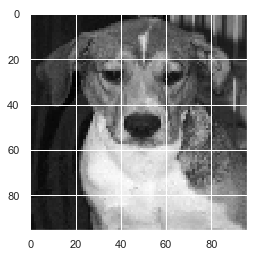

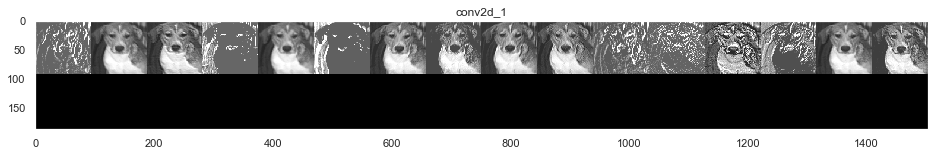

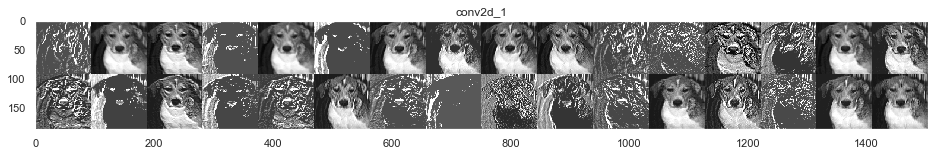

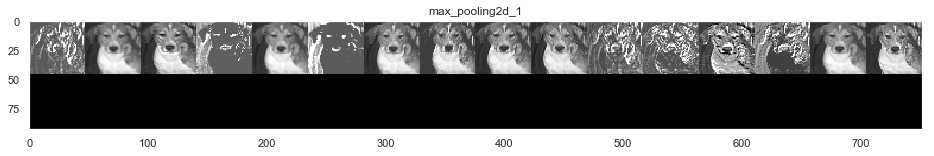

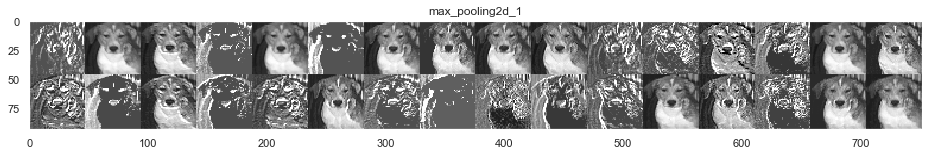

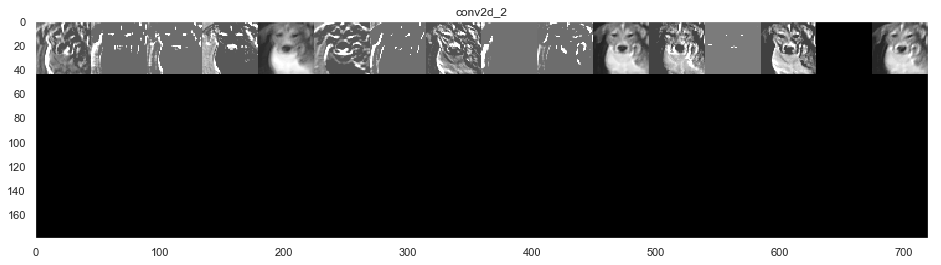

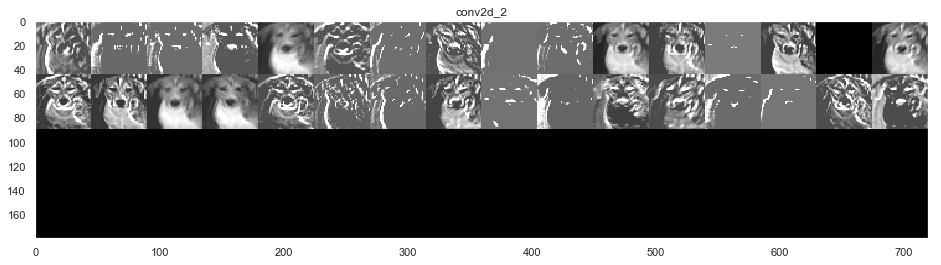

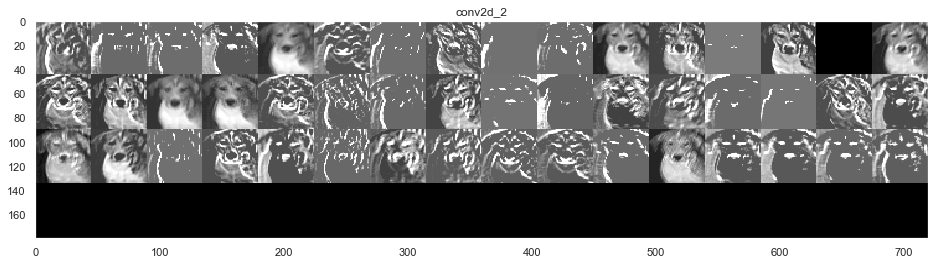

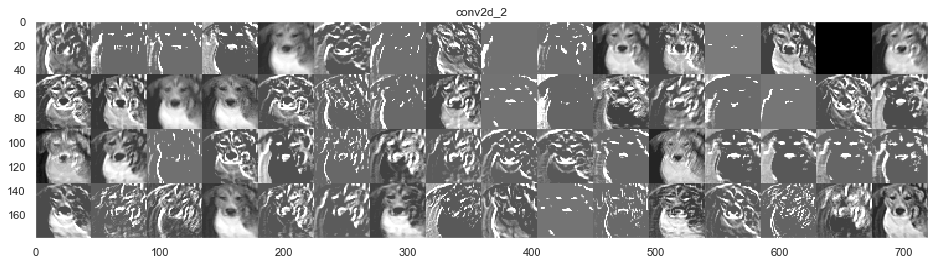

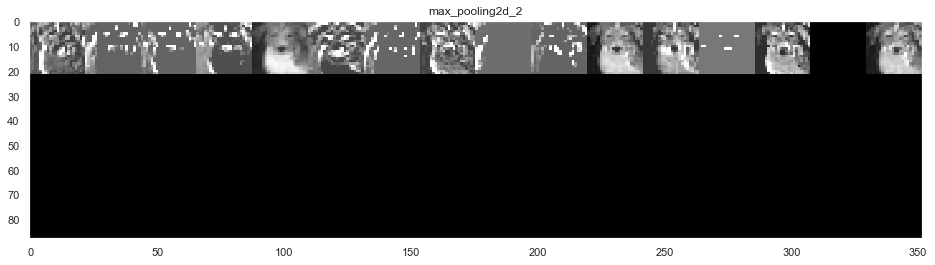

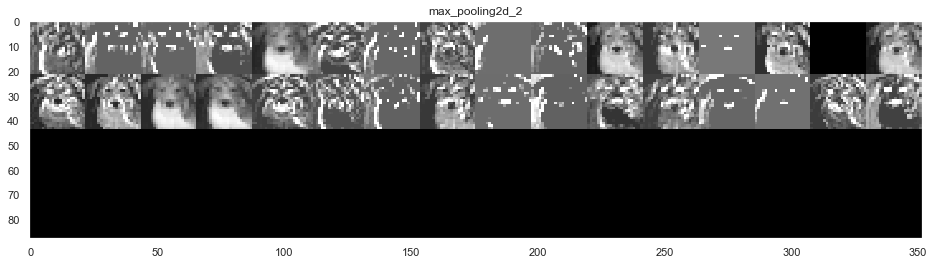

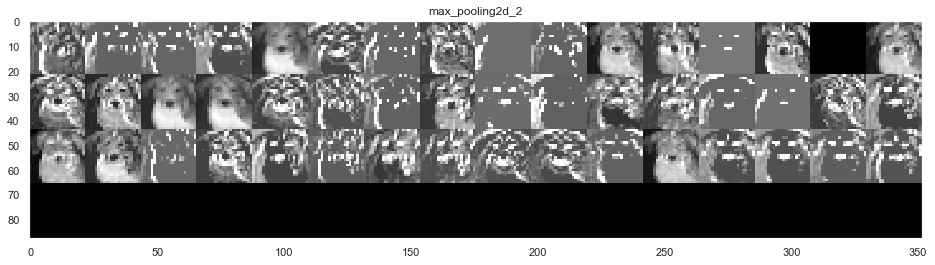

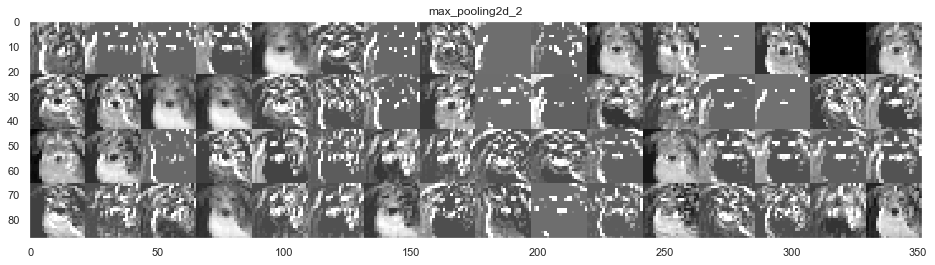

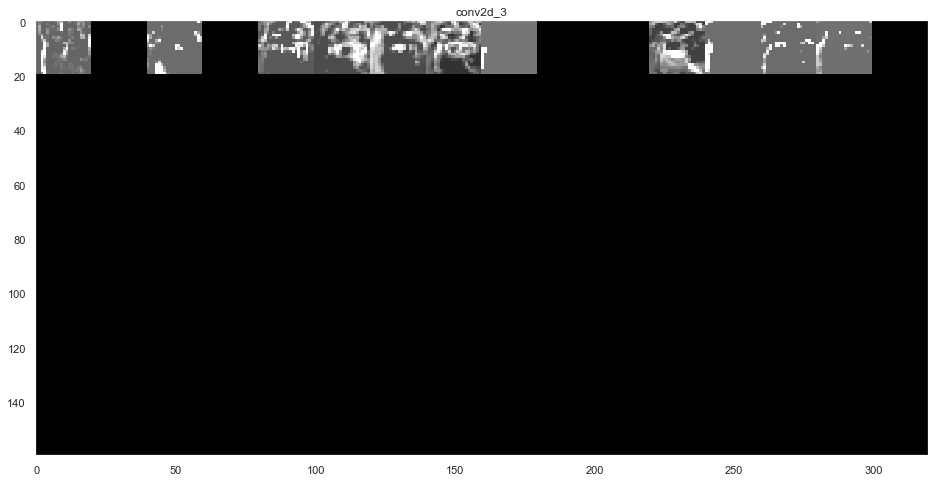

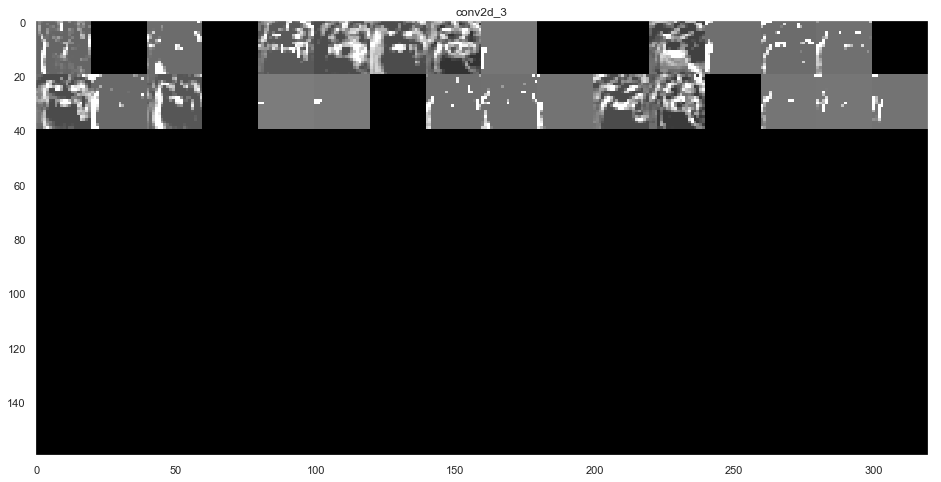

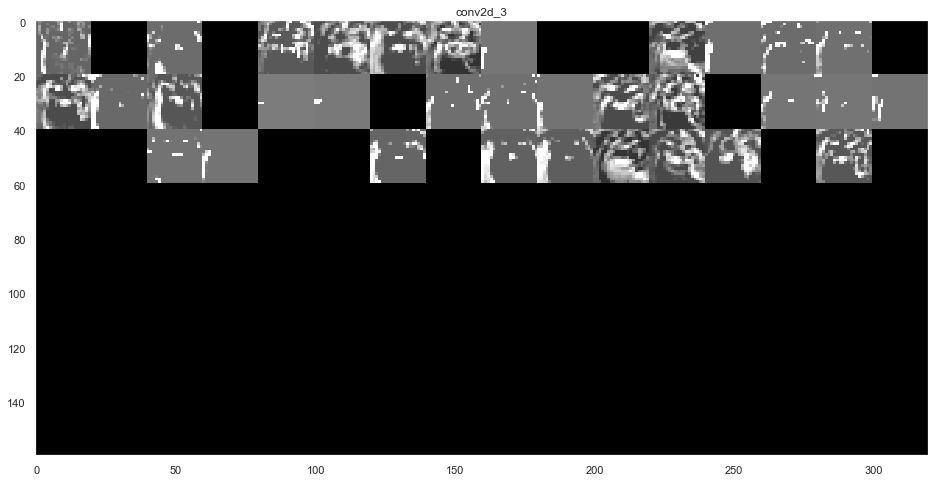

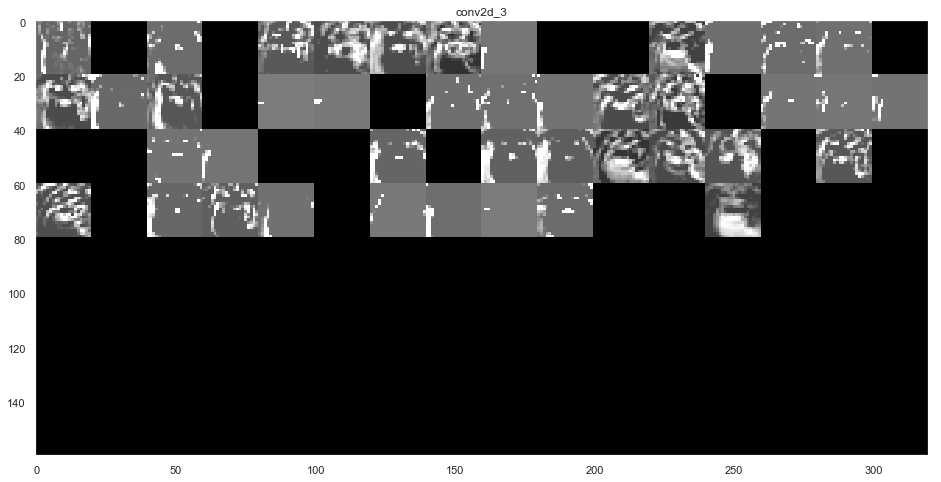

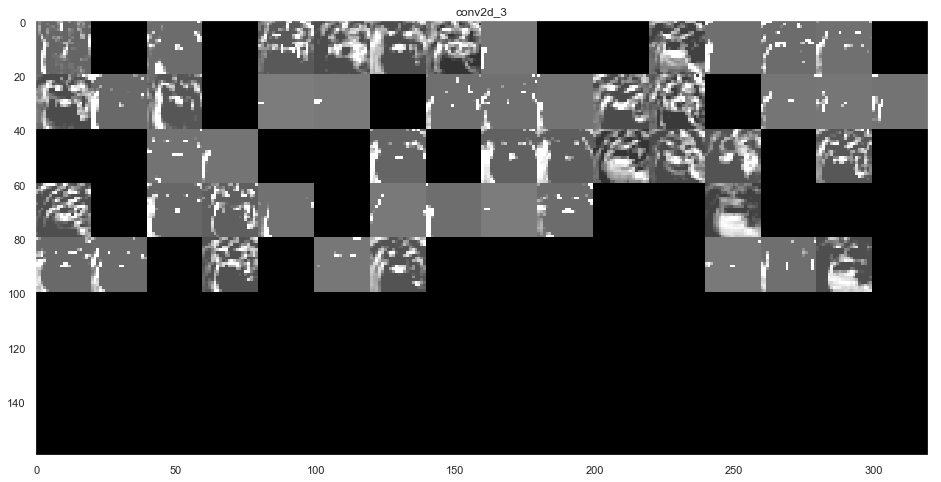

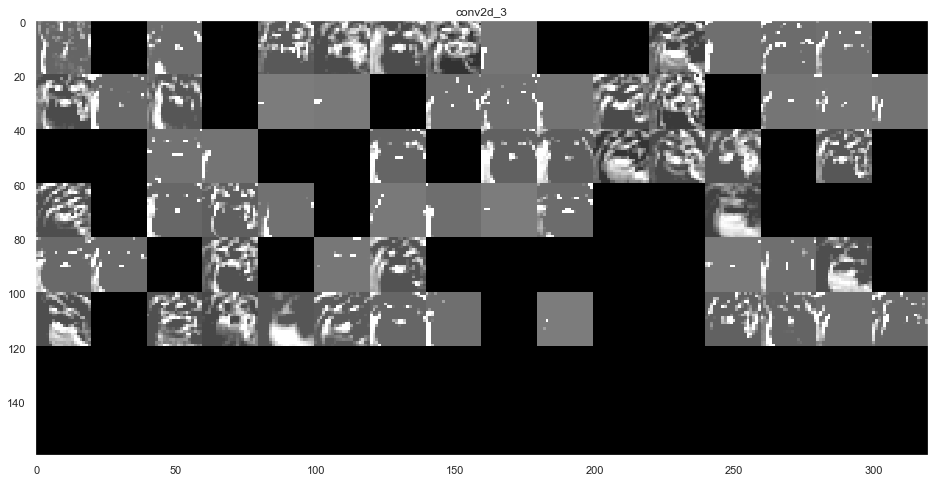

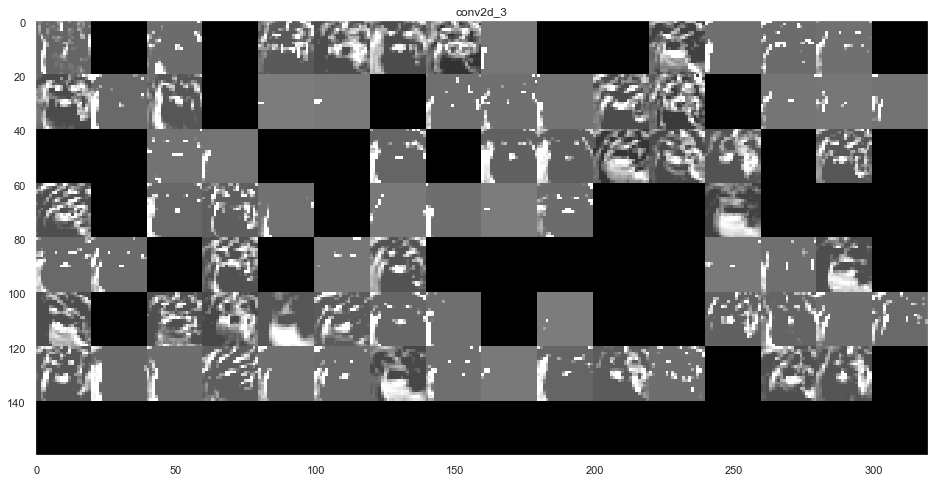

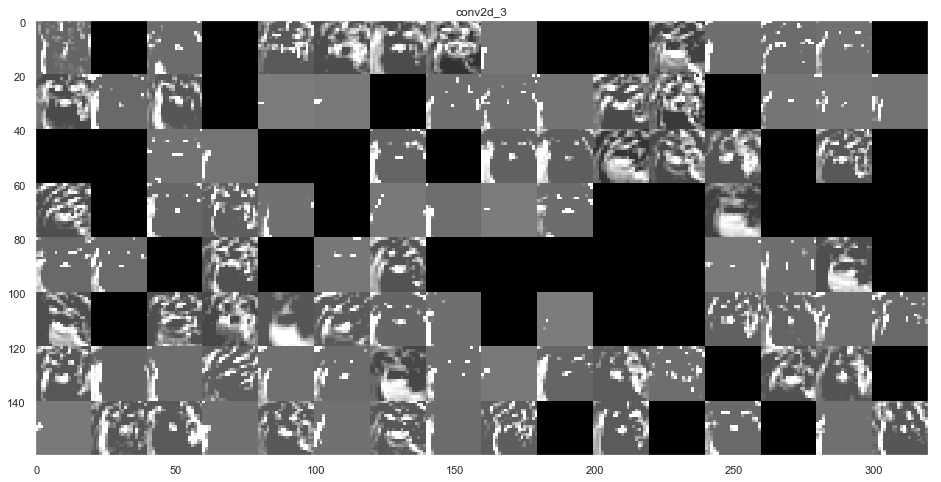

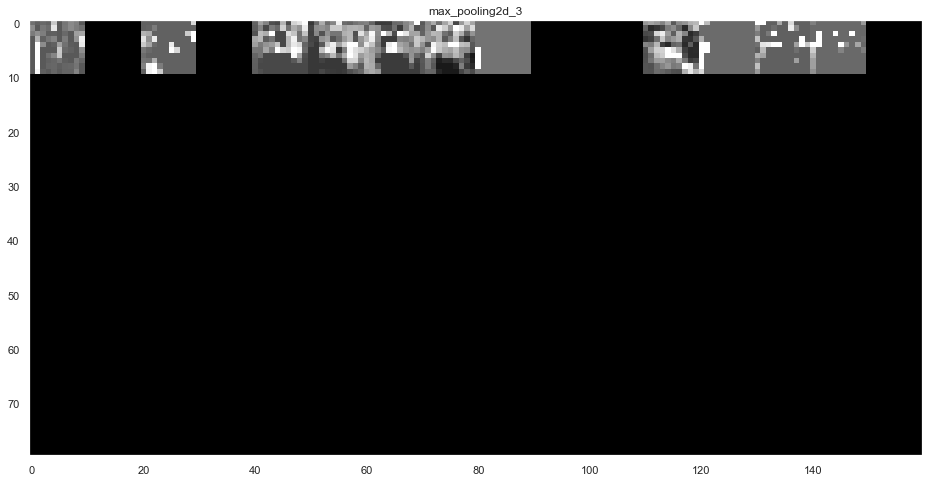

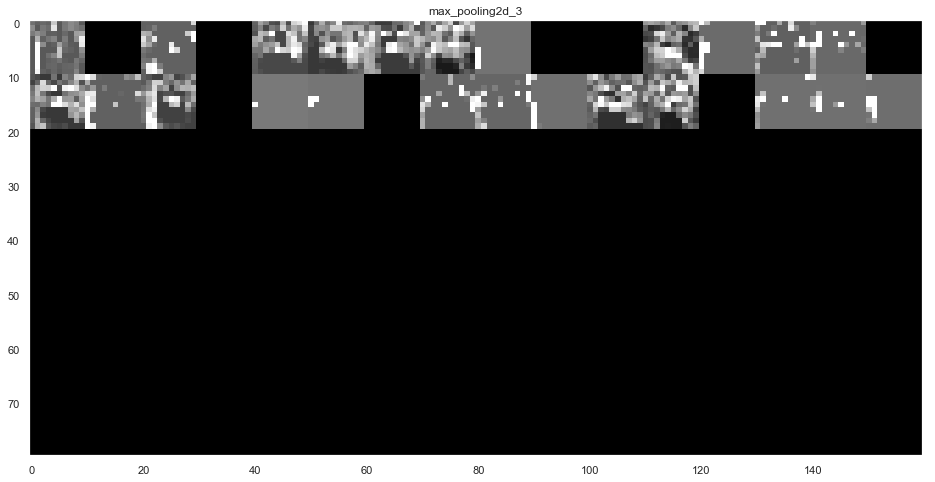

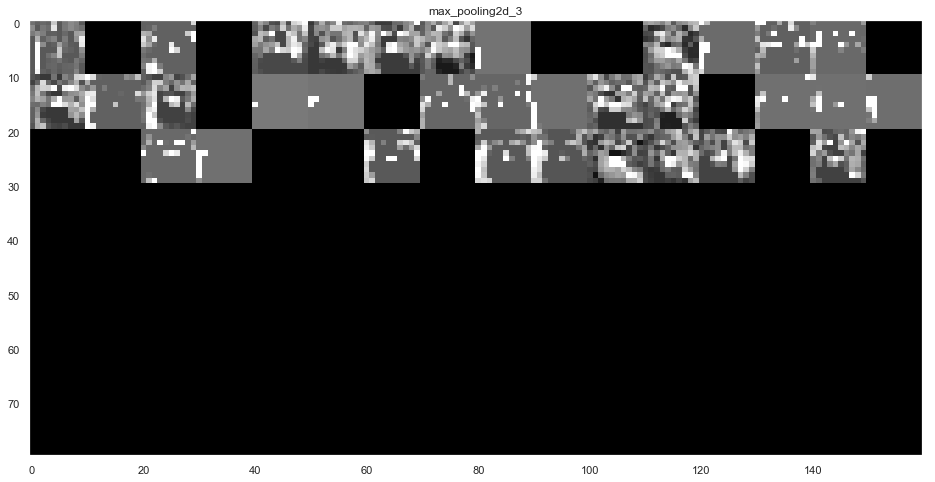

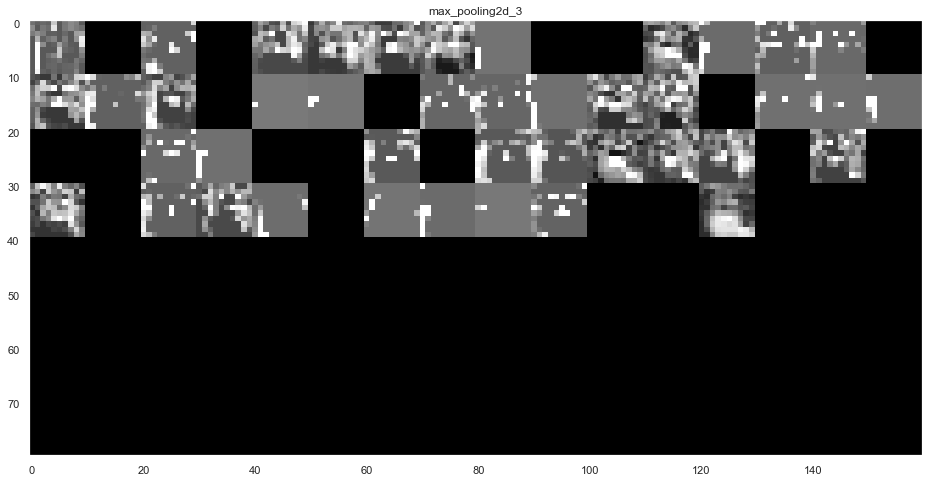

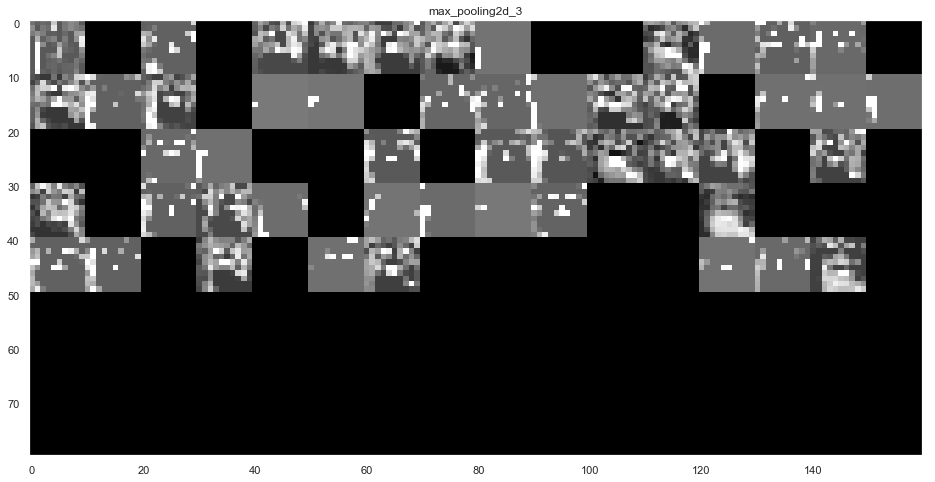

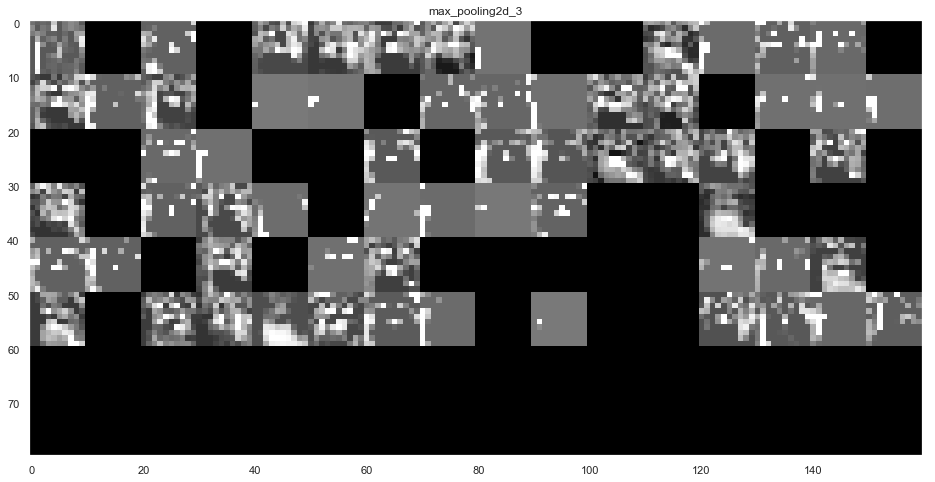

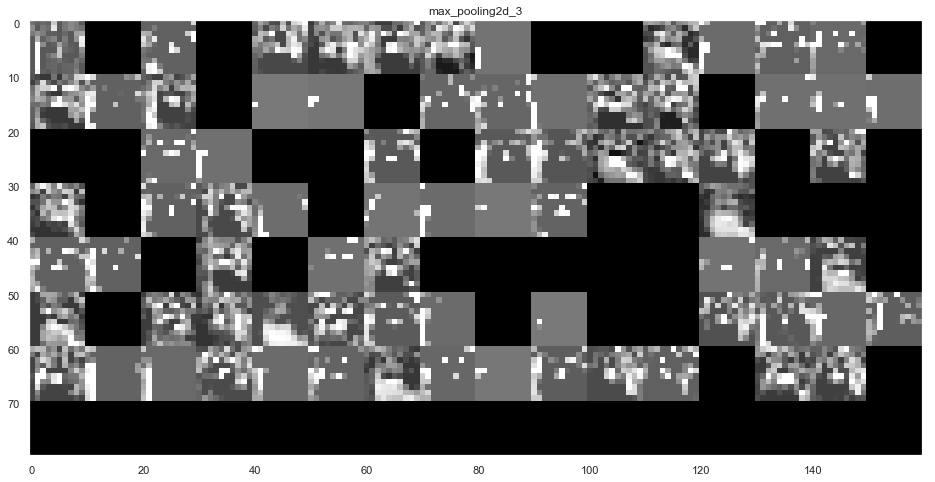

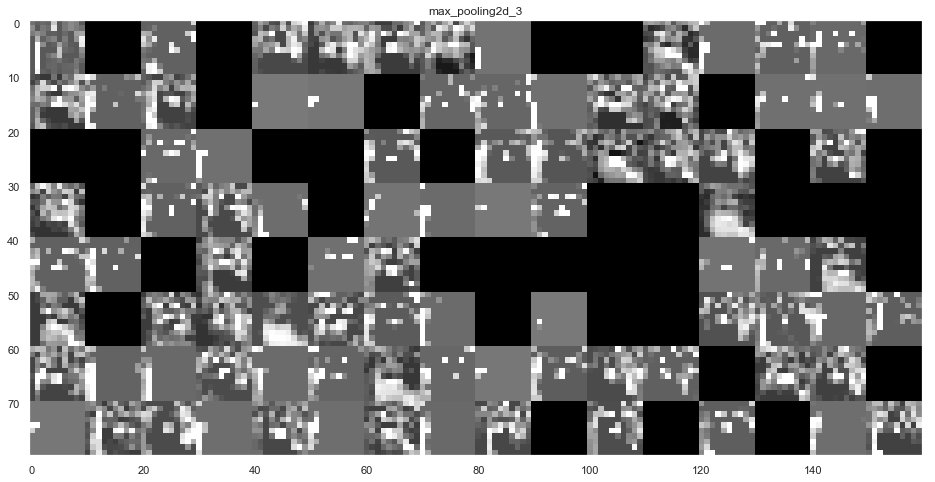

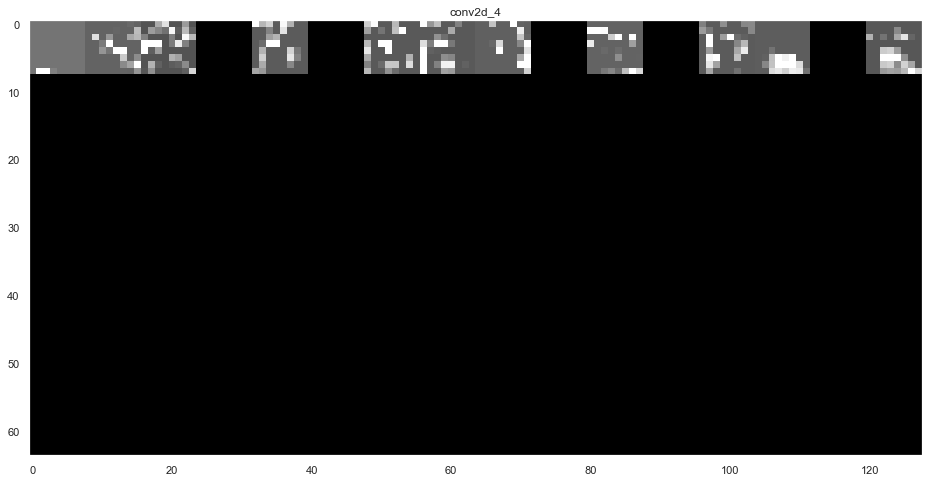

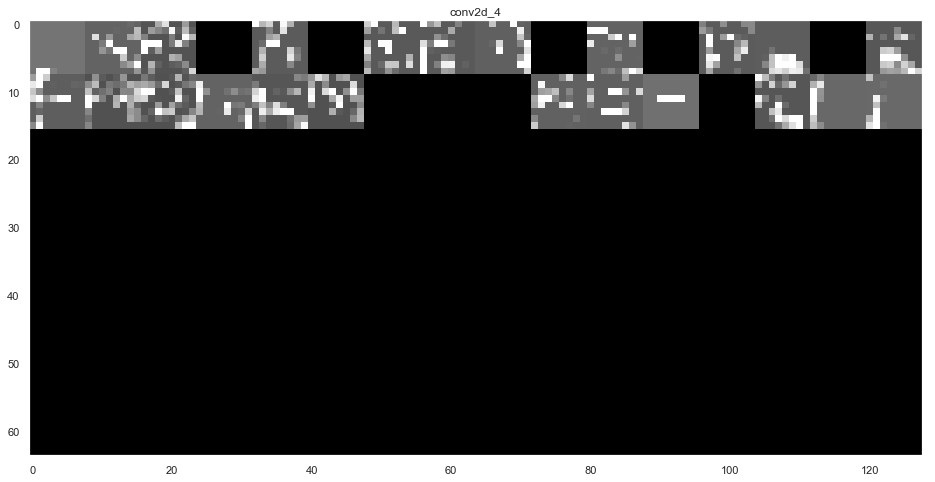

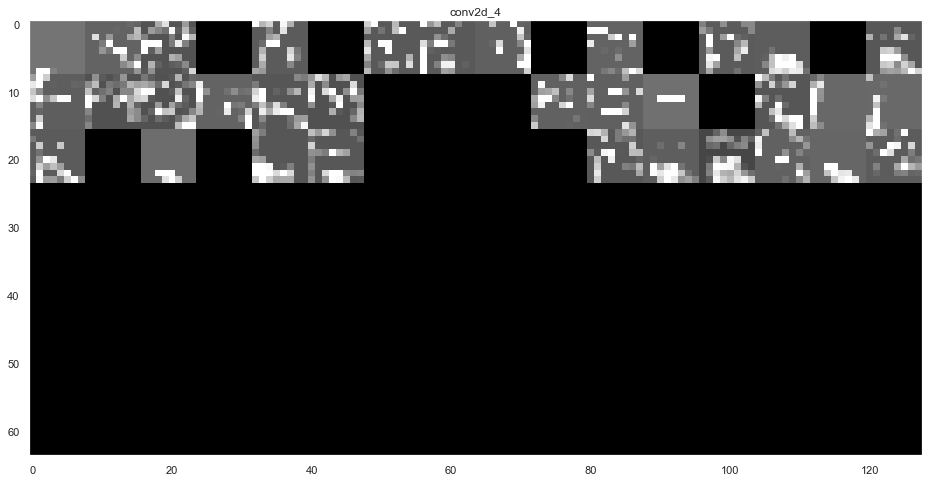

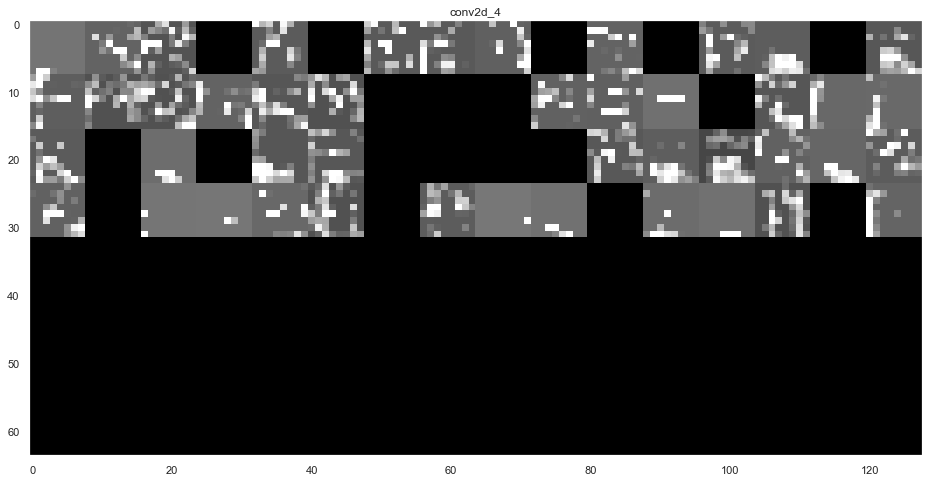

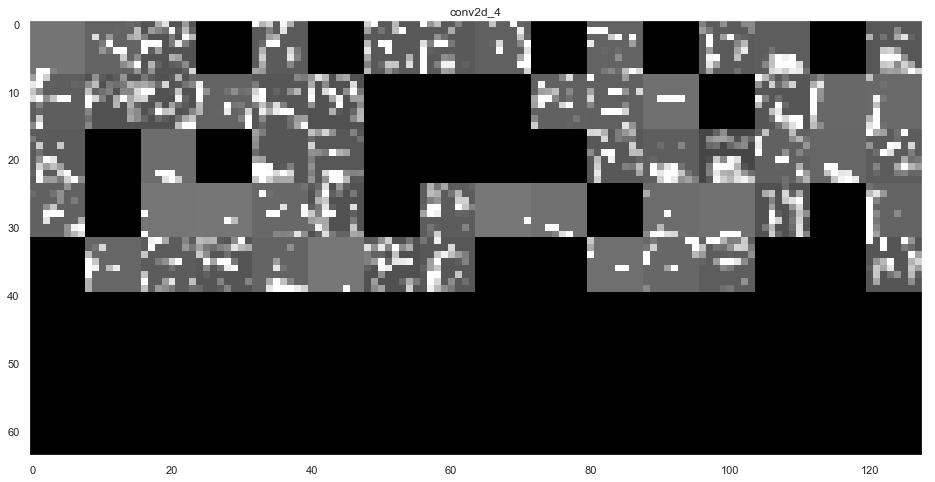

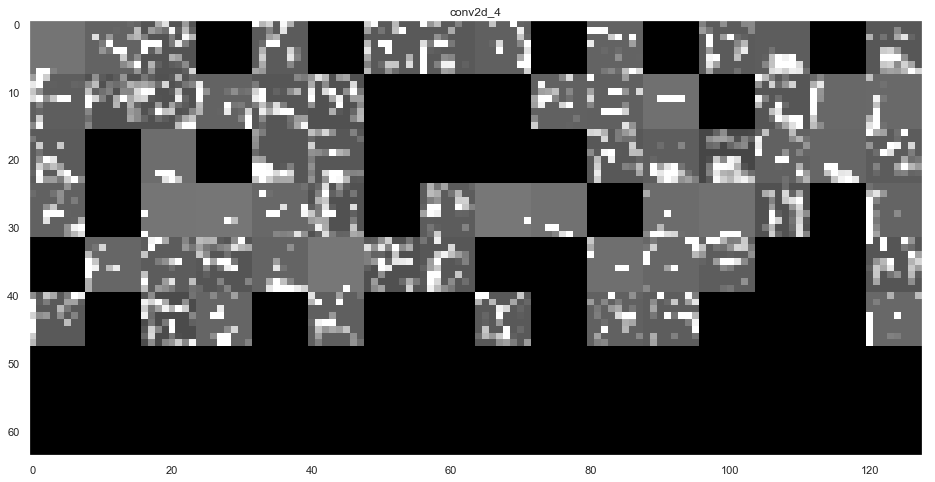

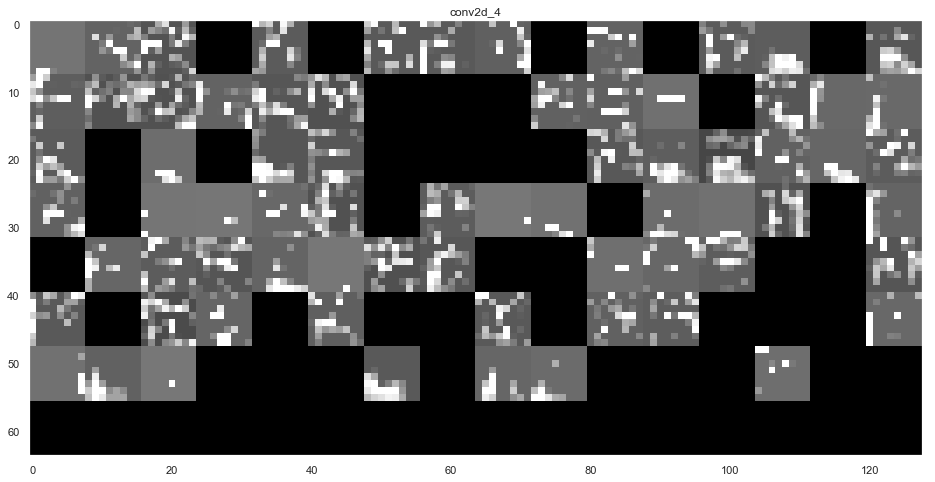

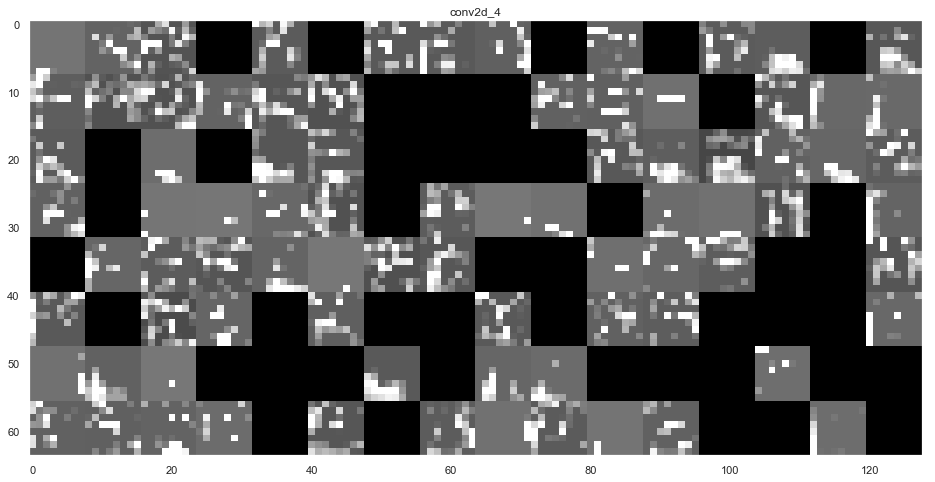

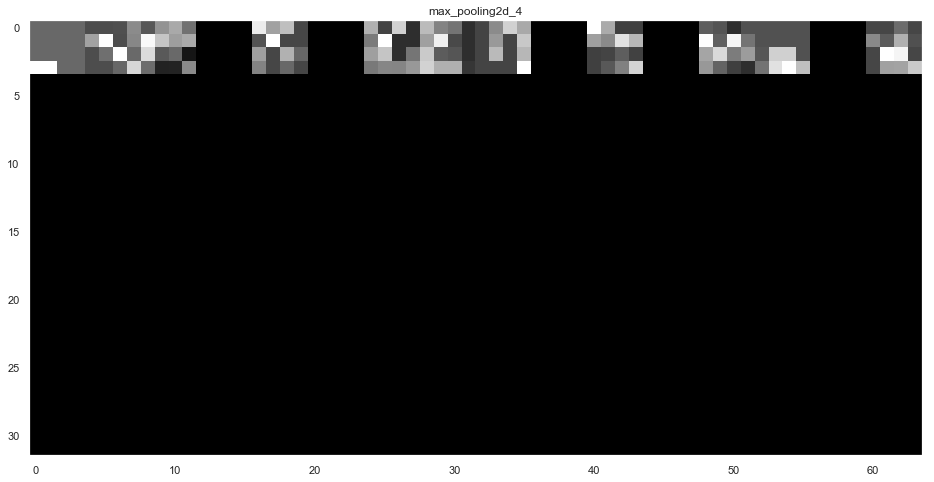

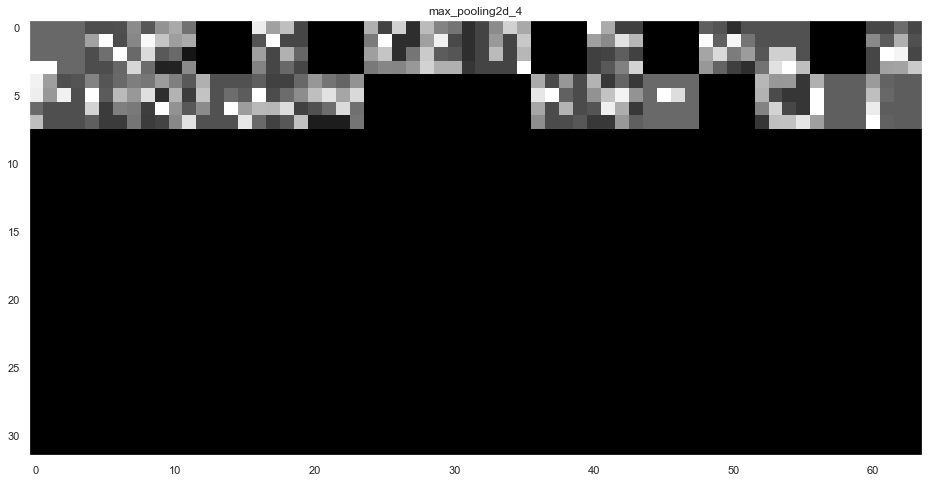

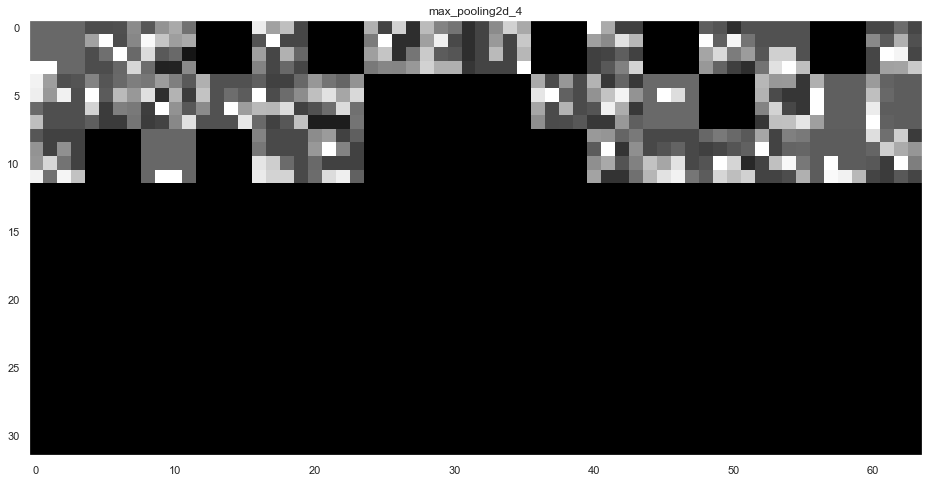

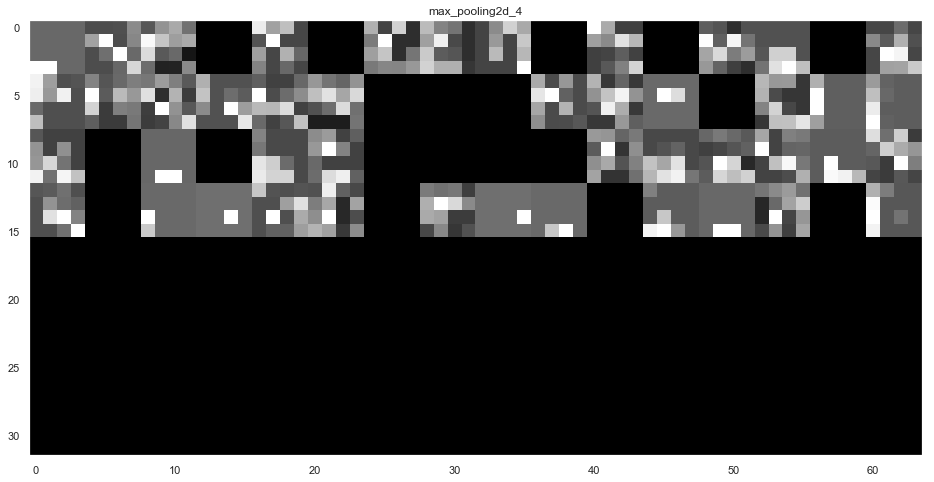

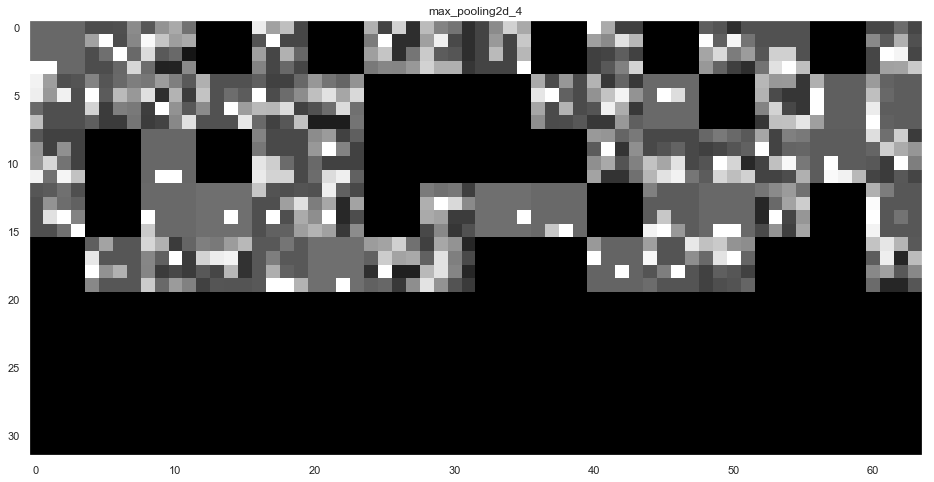

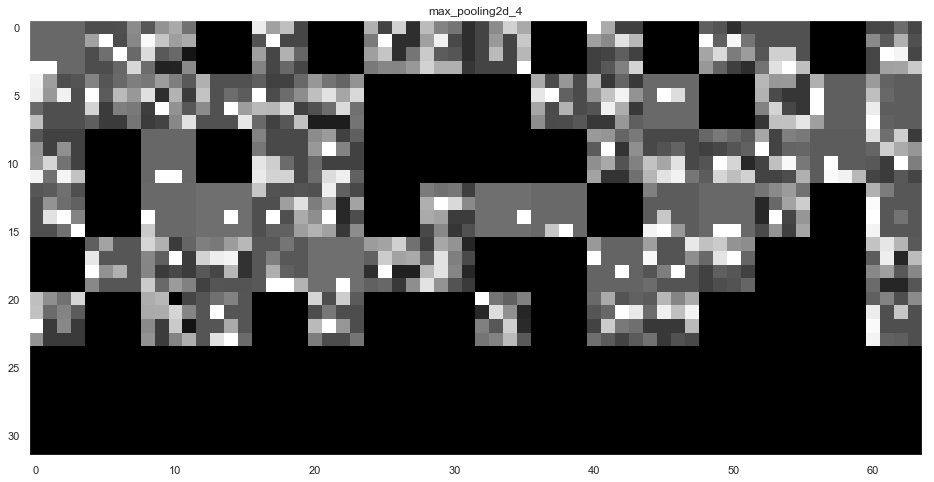

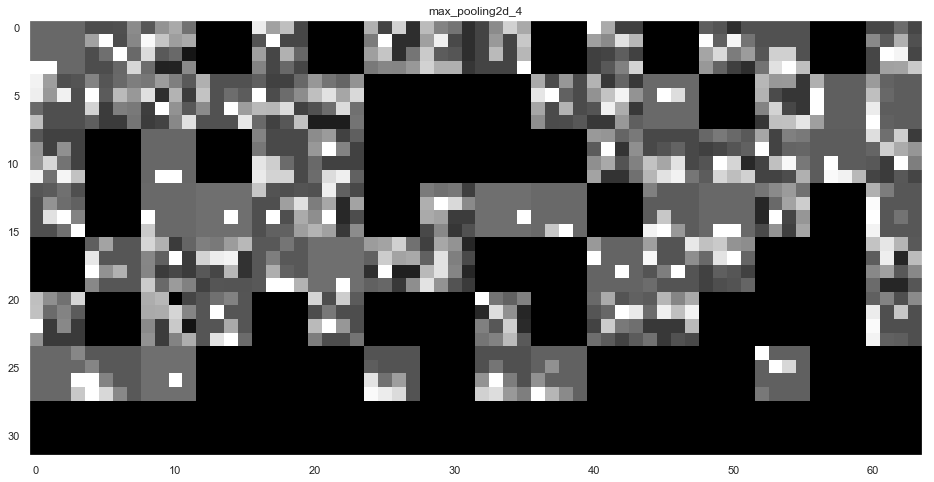

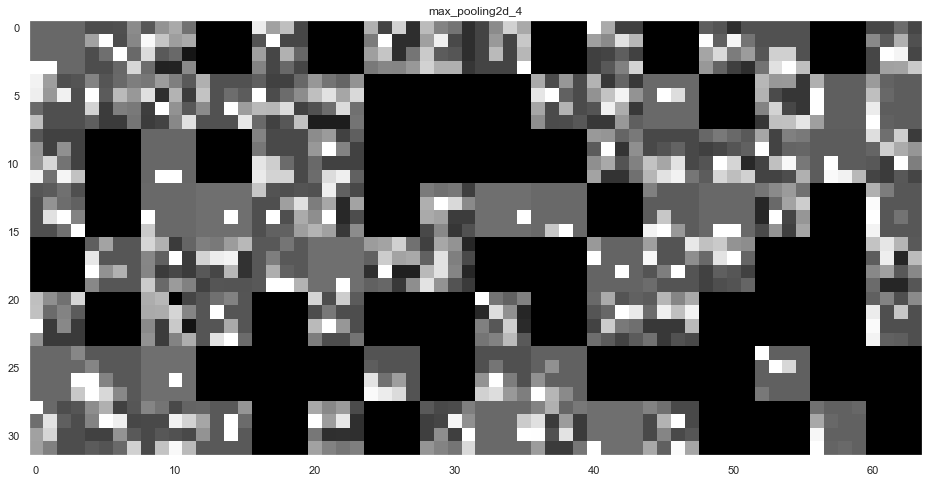

In [122]:
# played around  to find a good image
# tried this a few different times
img_path = os.path.join(train_path, 'dog.4555.jpg')
viz_intermediate_activations(img_path, 8)

(1, 96, 96, 1)


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


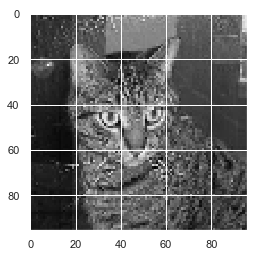

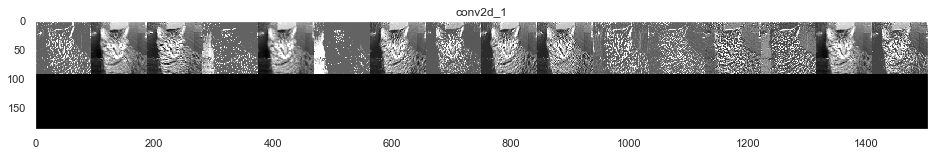

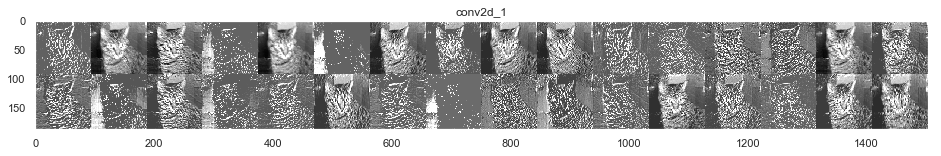

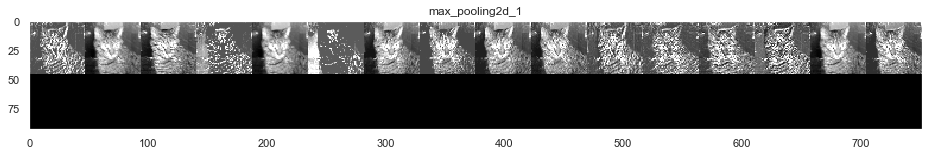

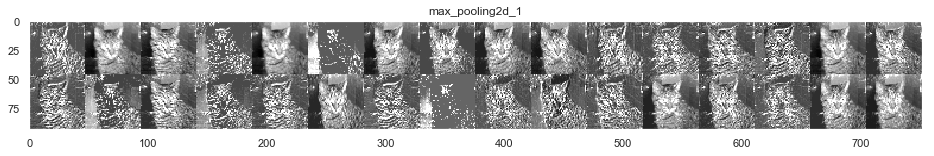

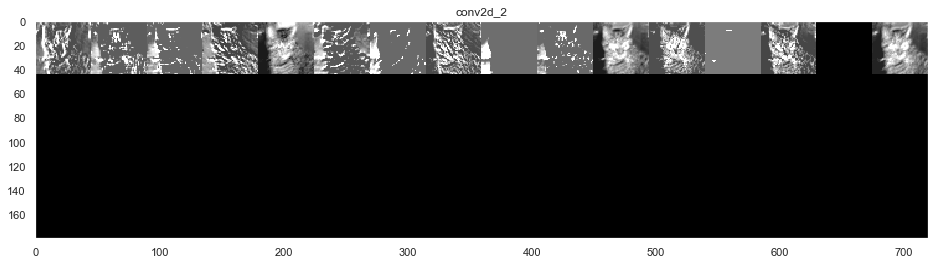

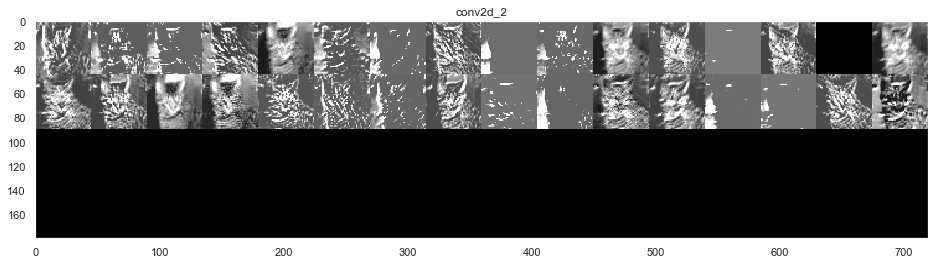

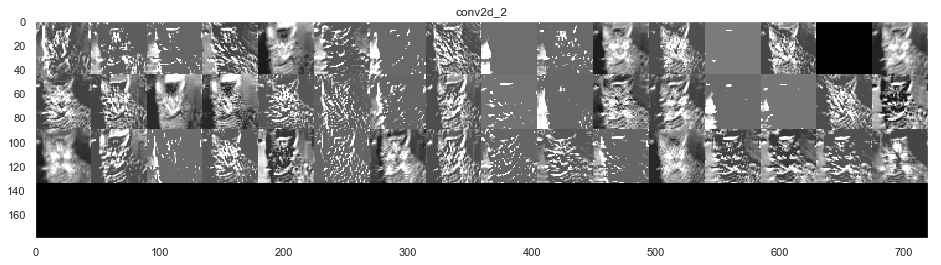

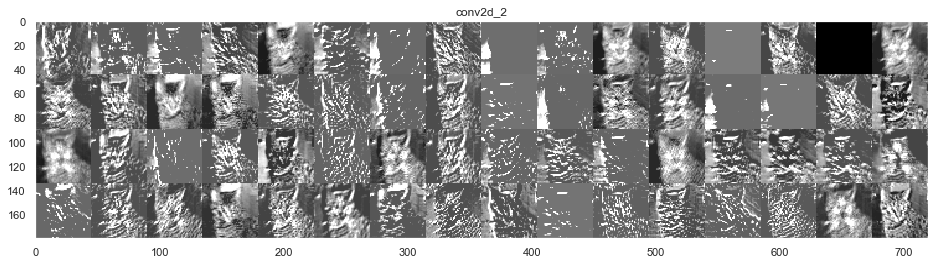

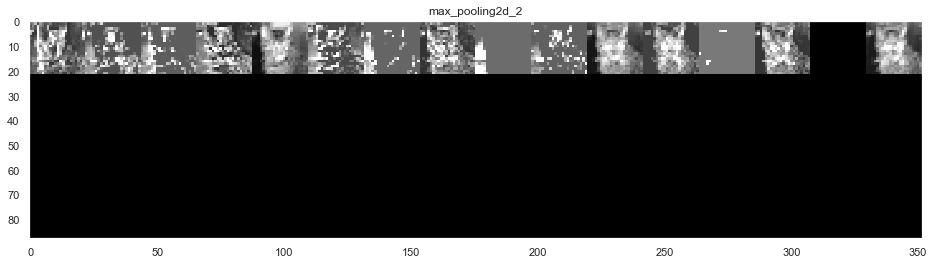

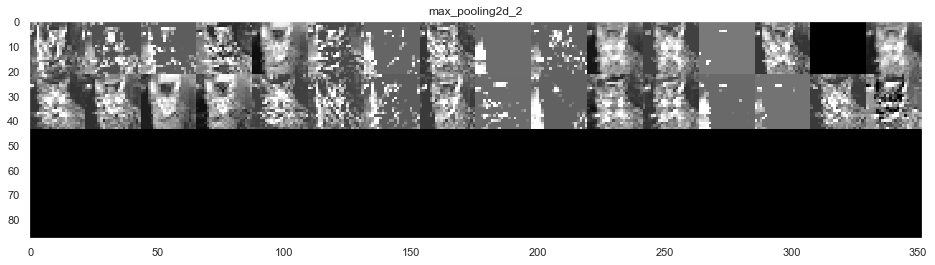

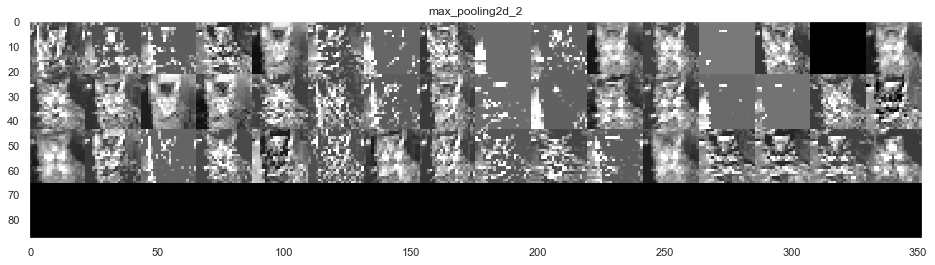

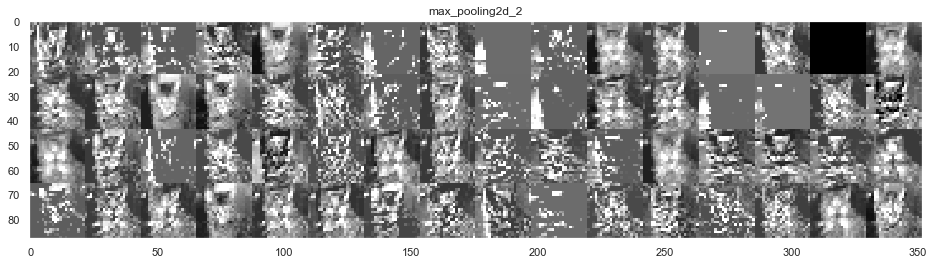

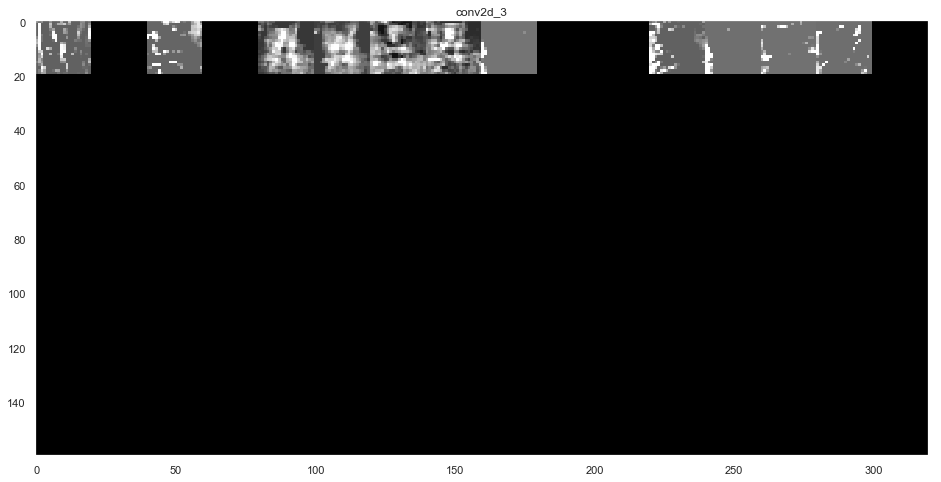

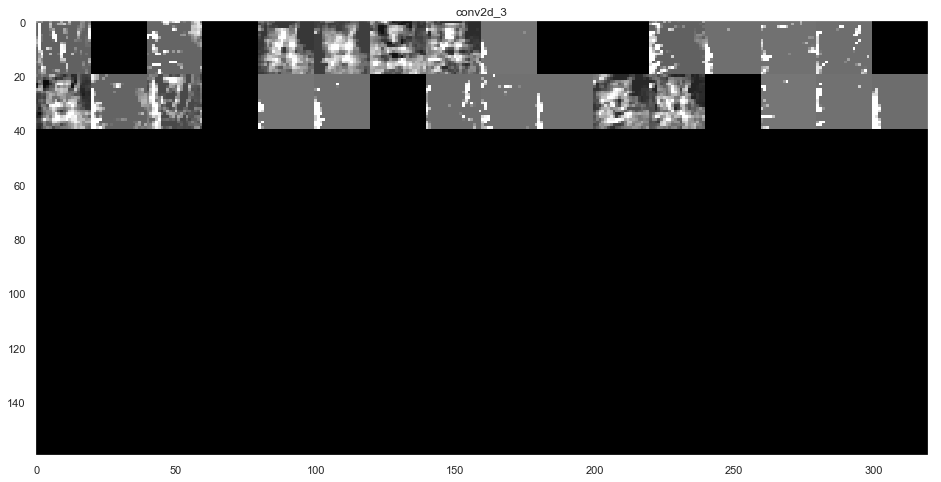

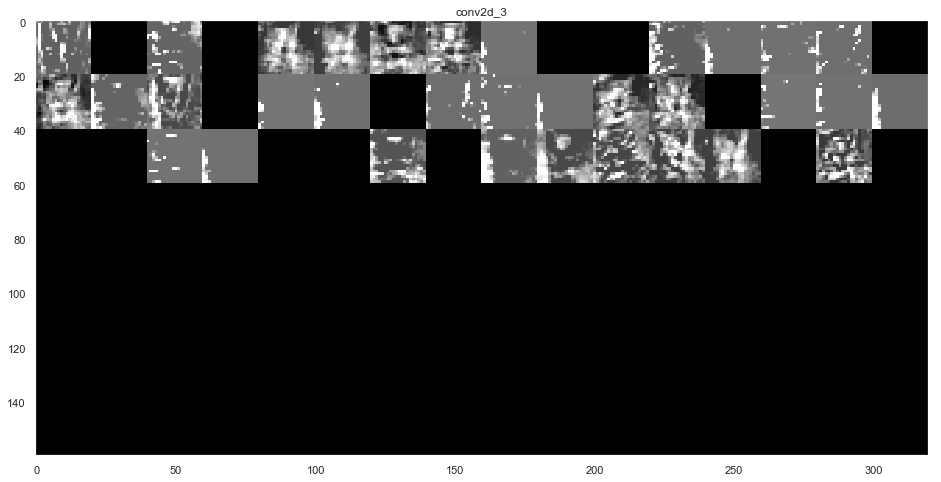

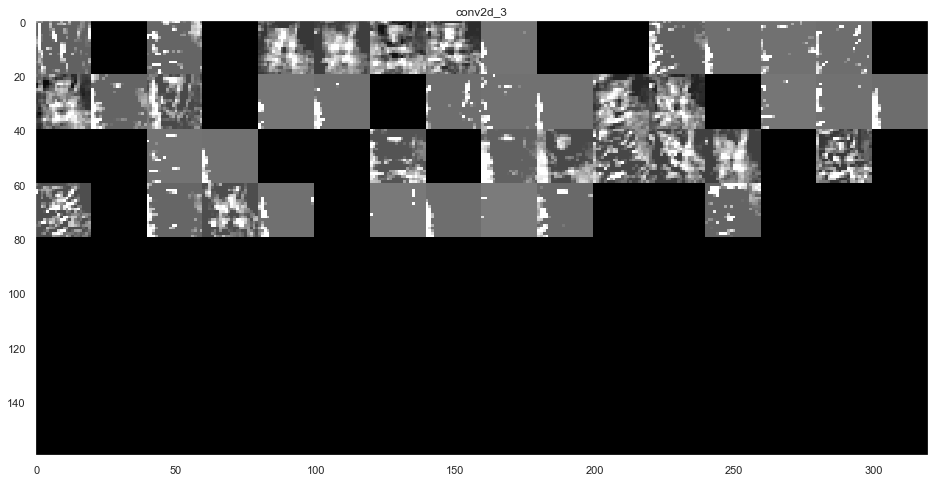

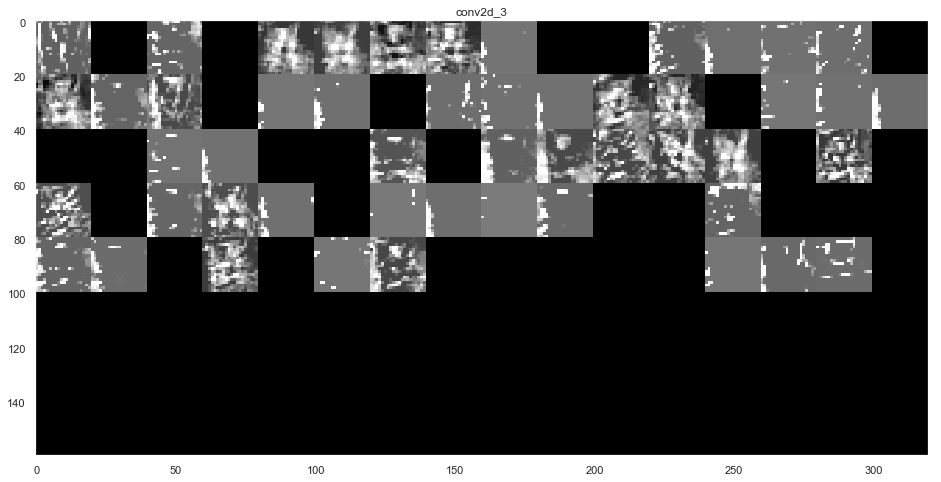

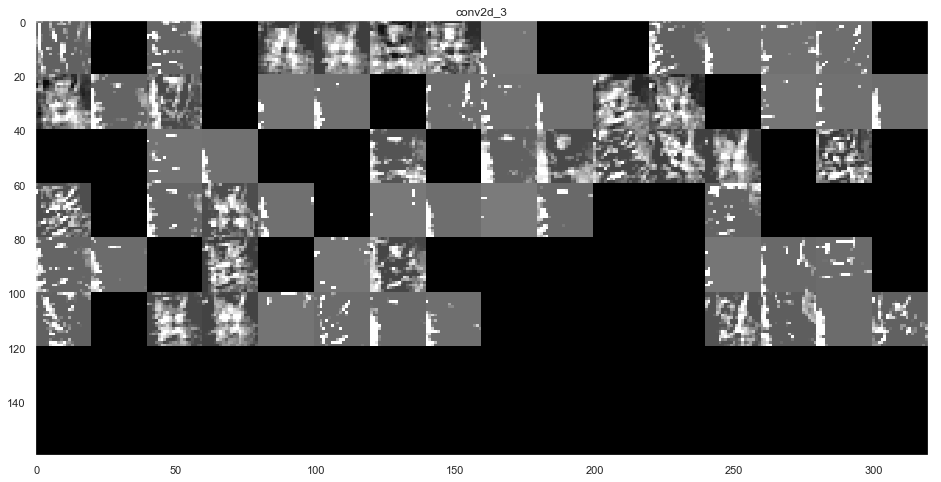

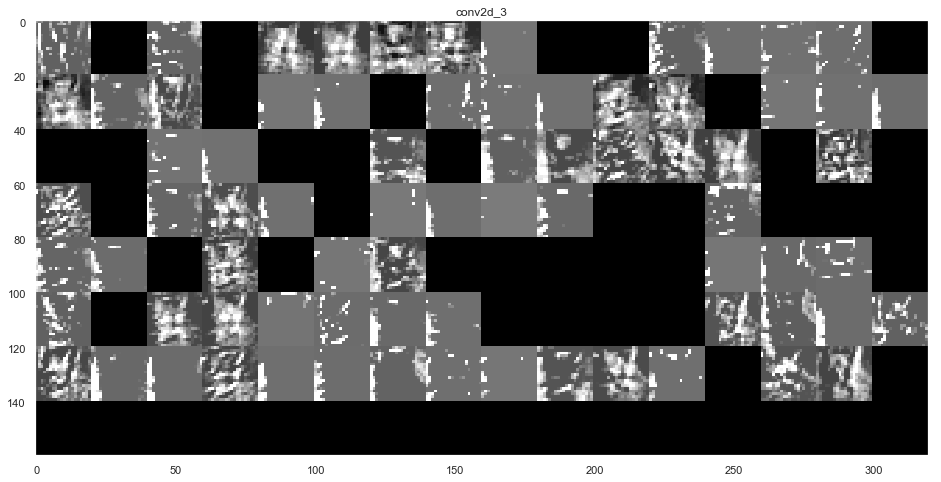

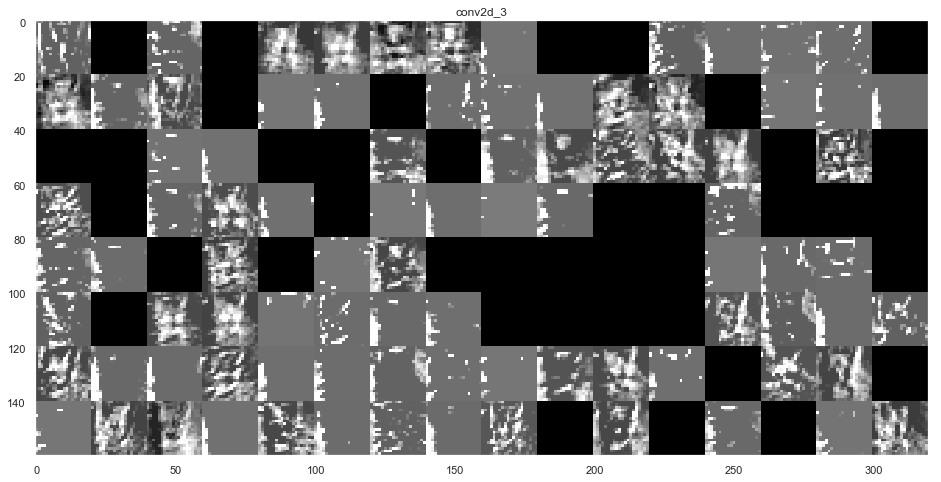

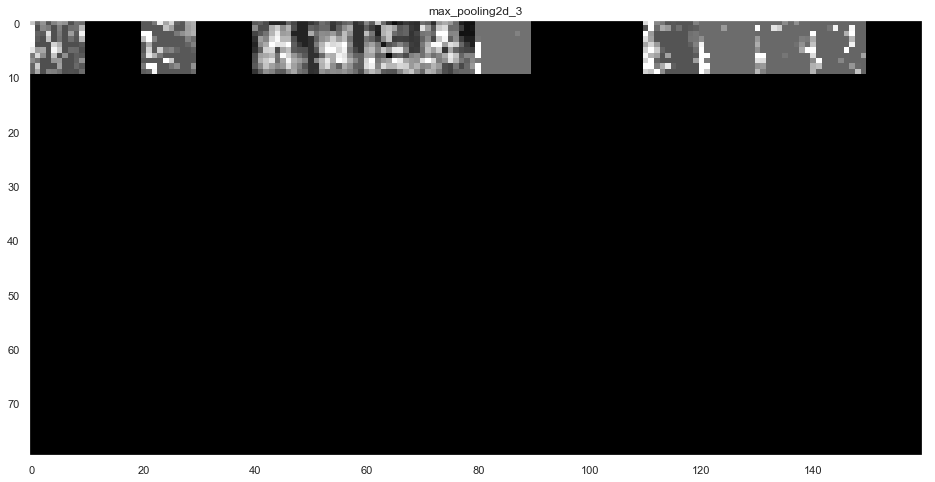

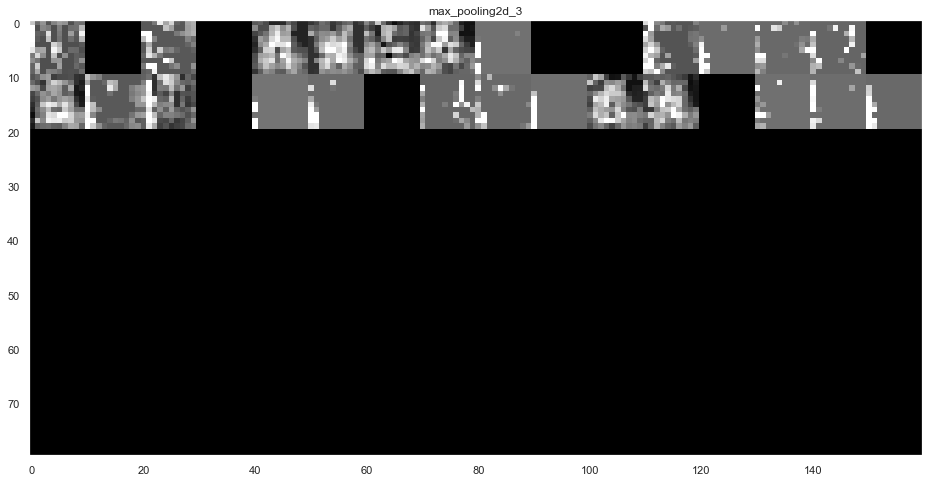

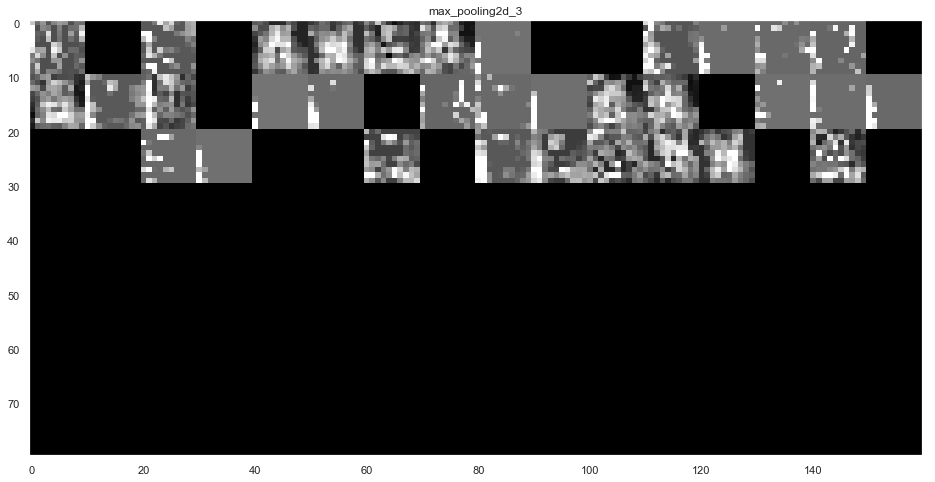

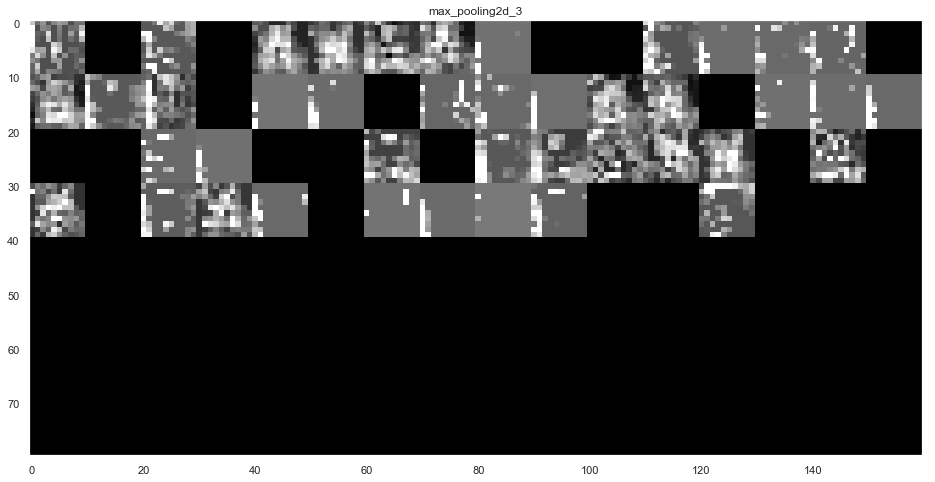

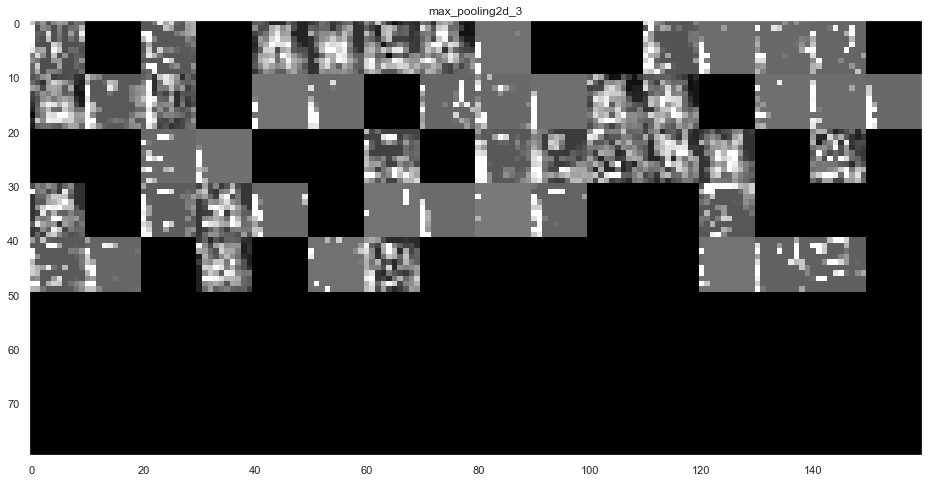

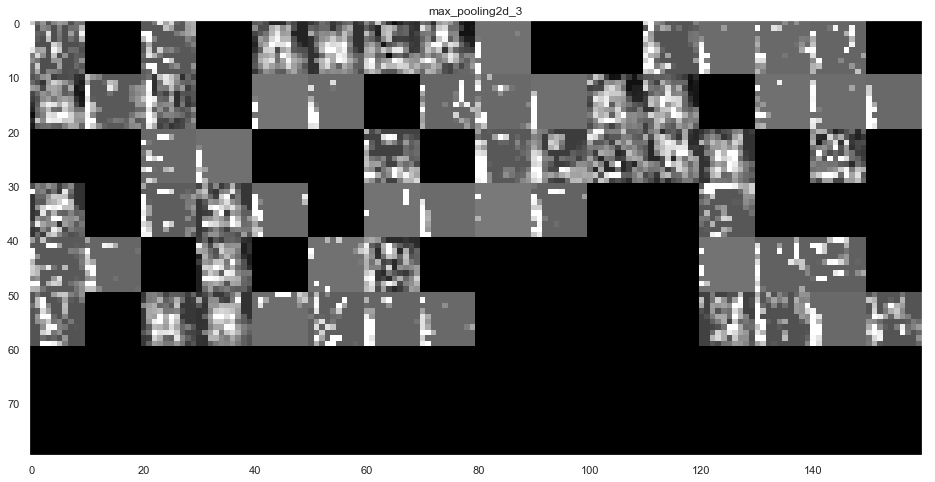

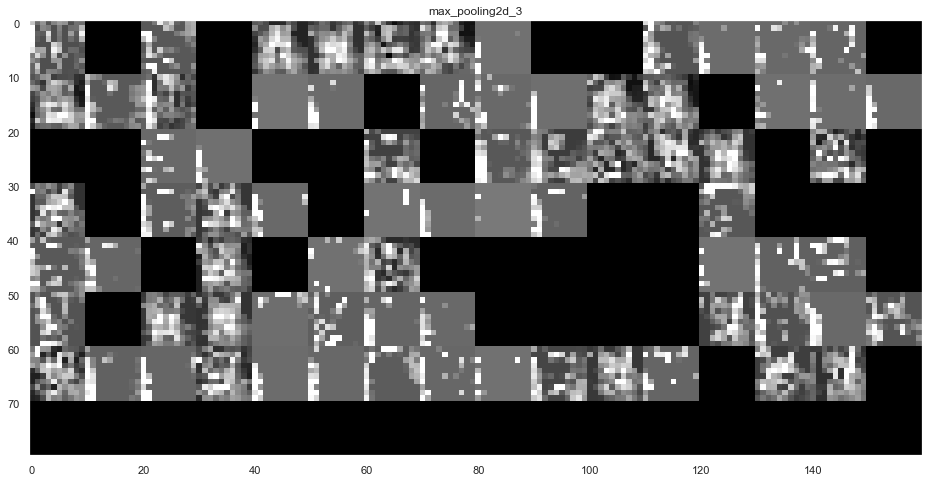

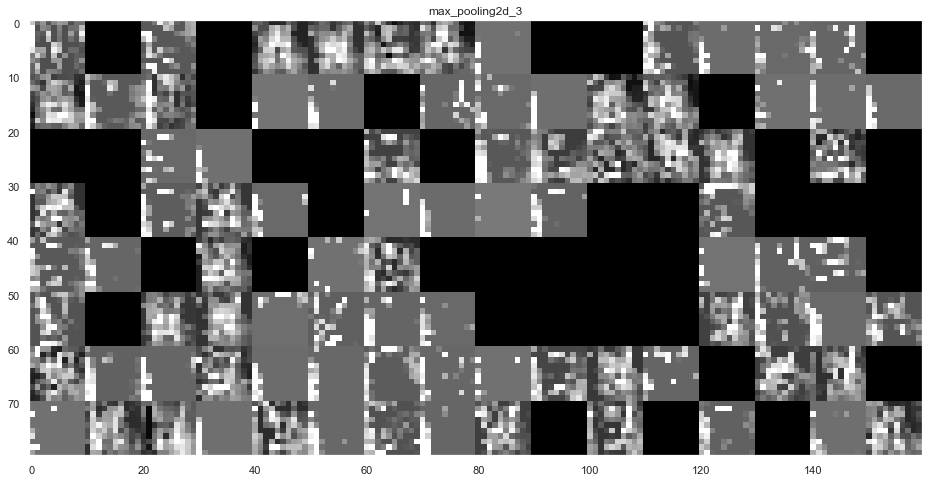

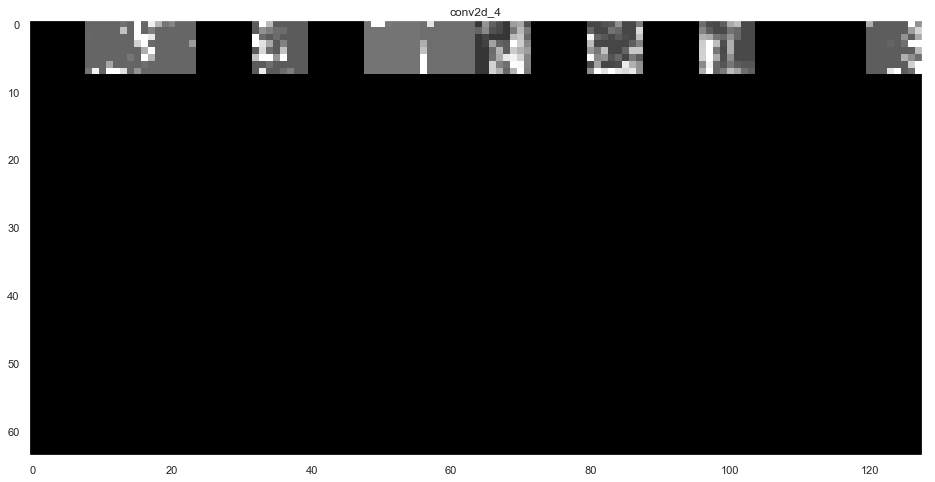

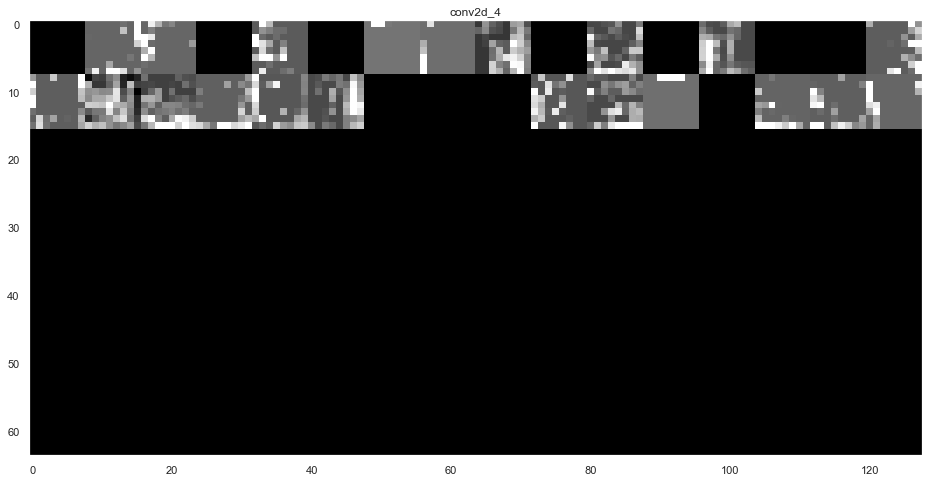

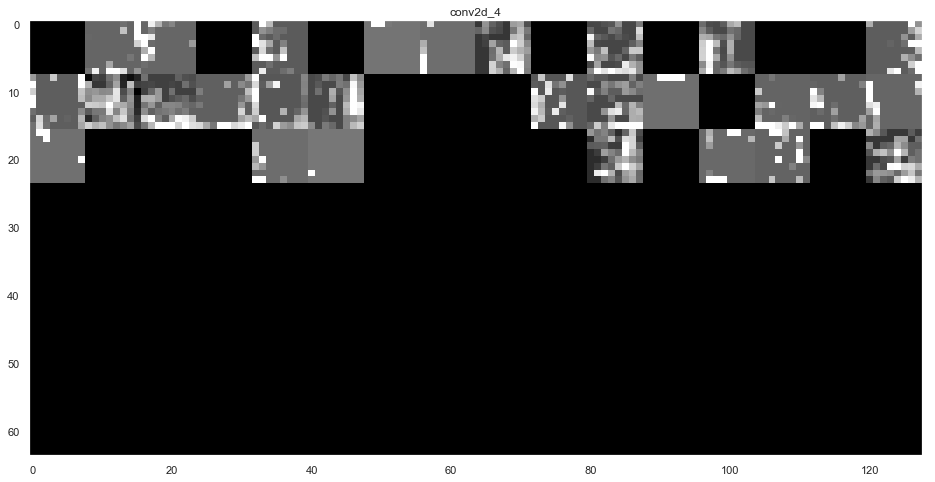

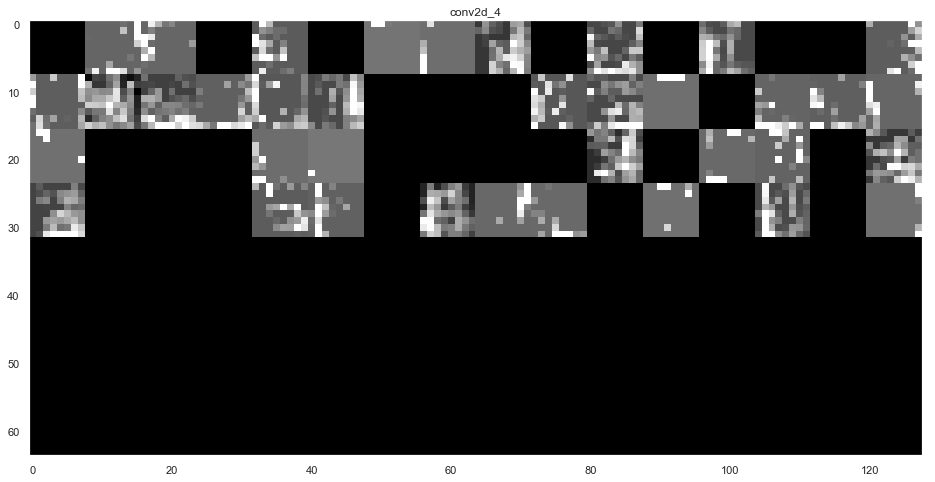

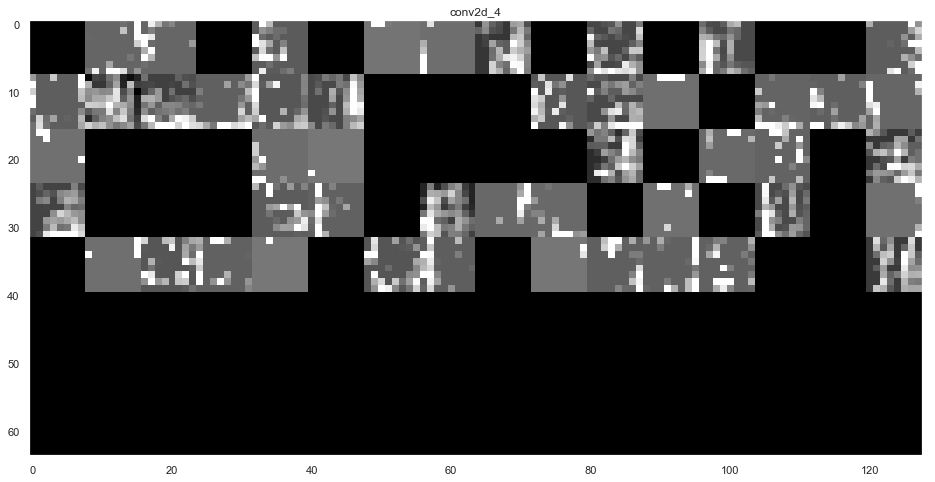

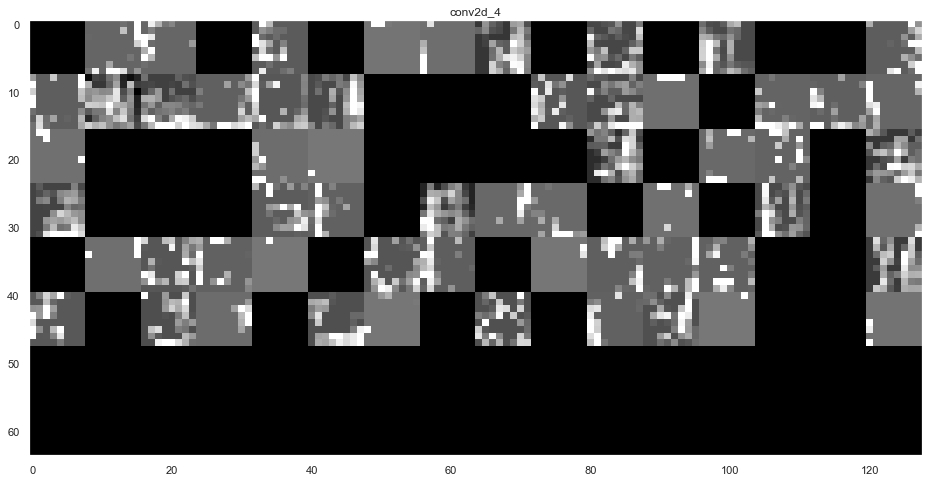

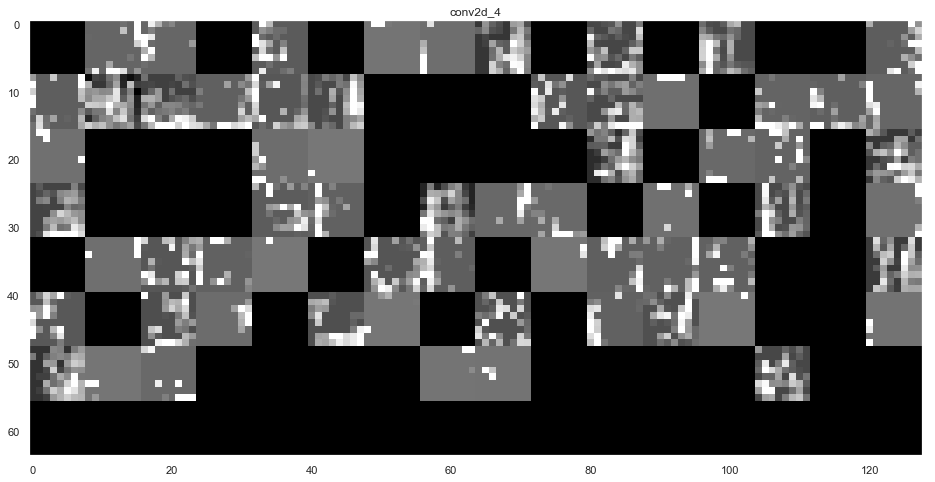

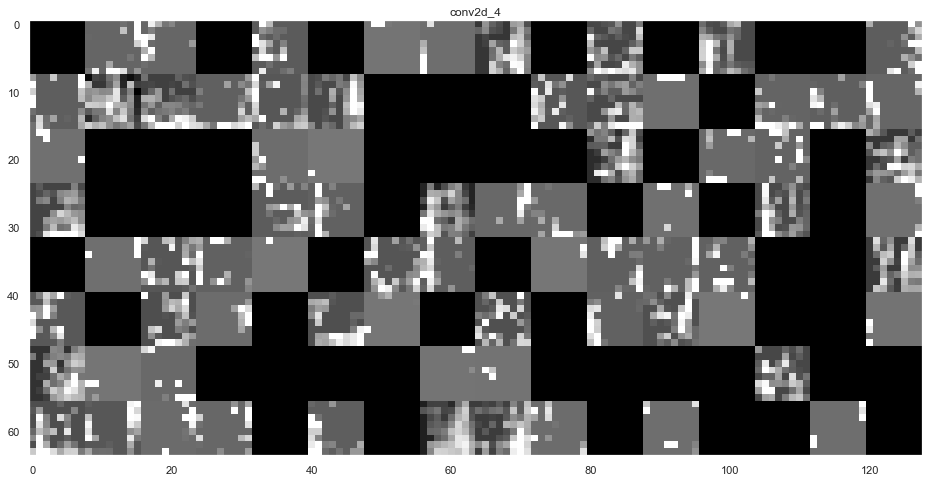

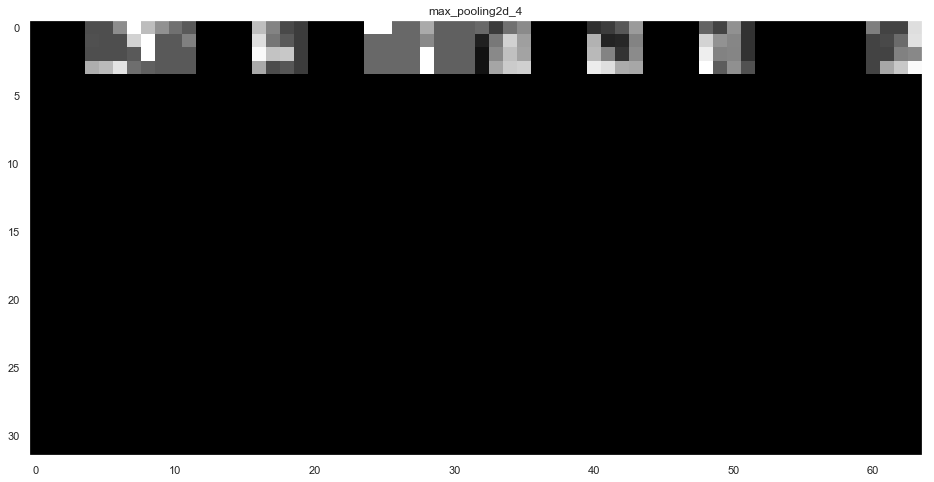

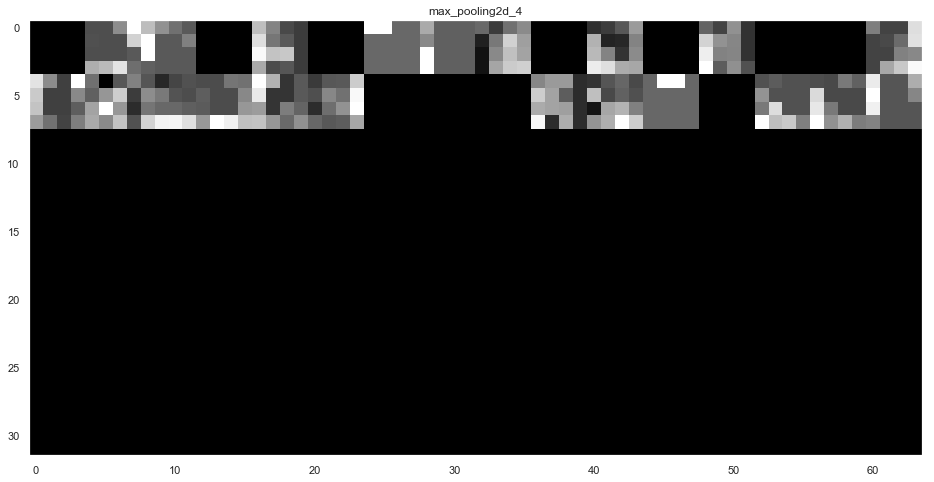

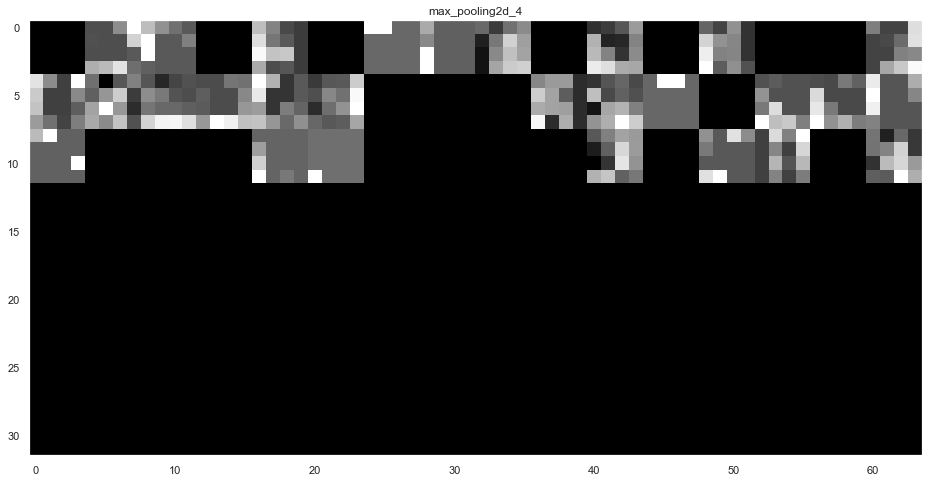

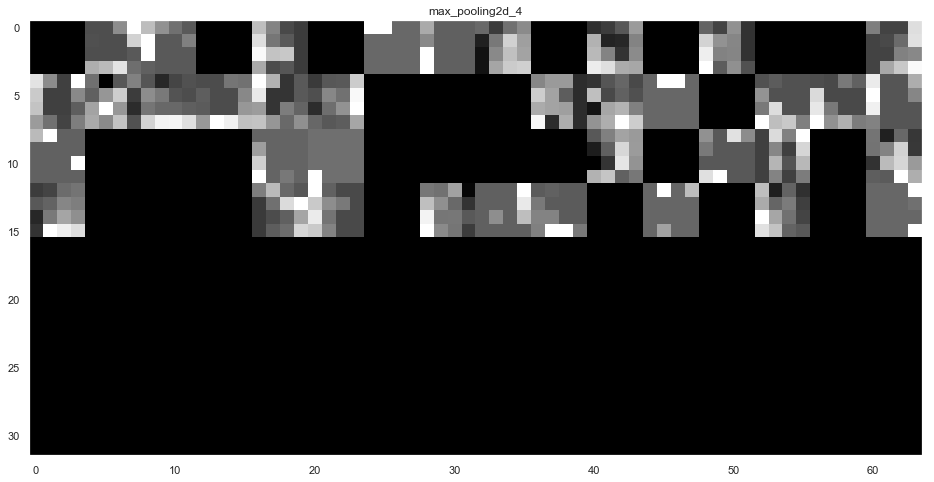

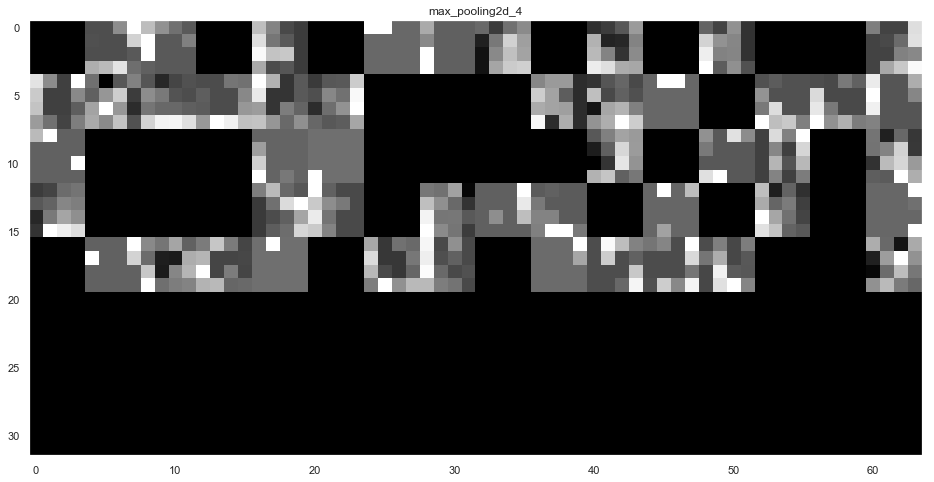

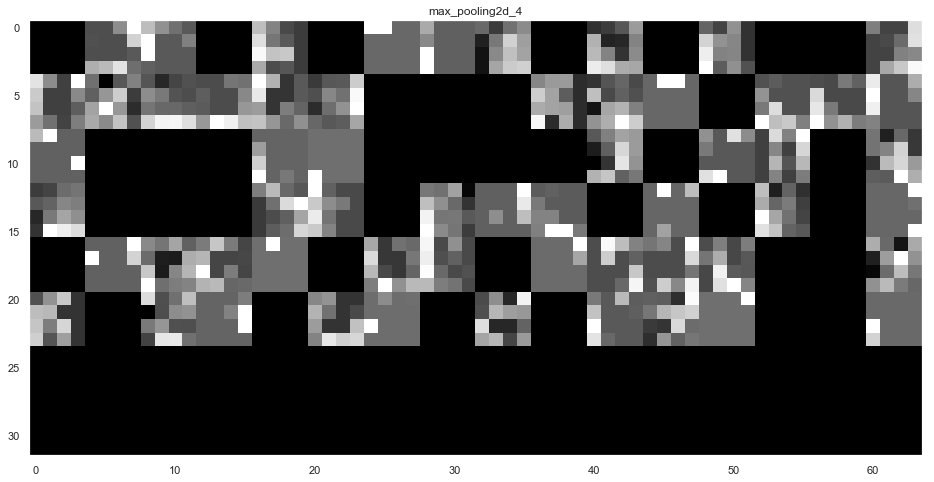

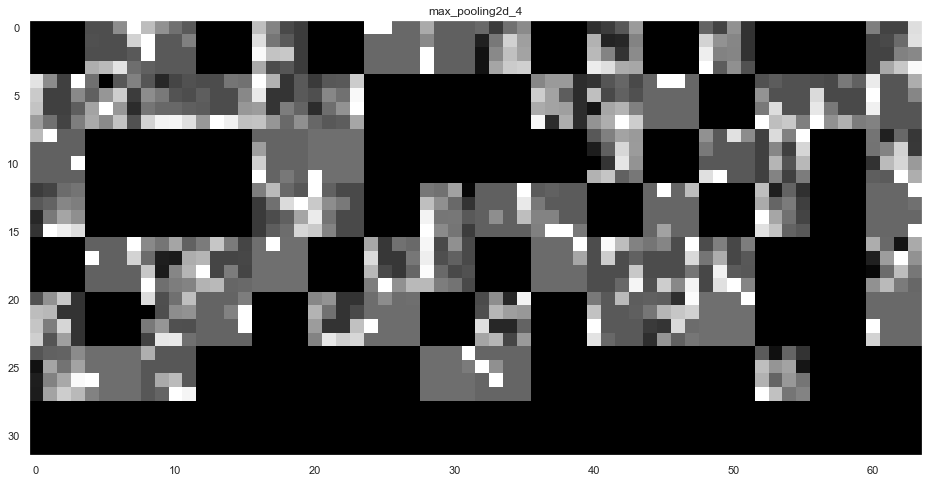

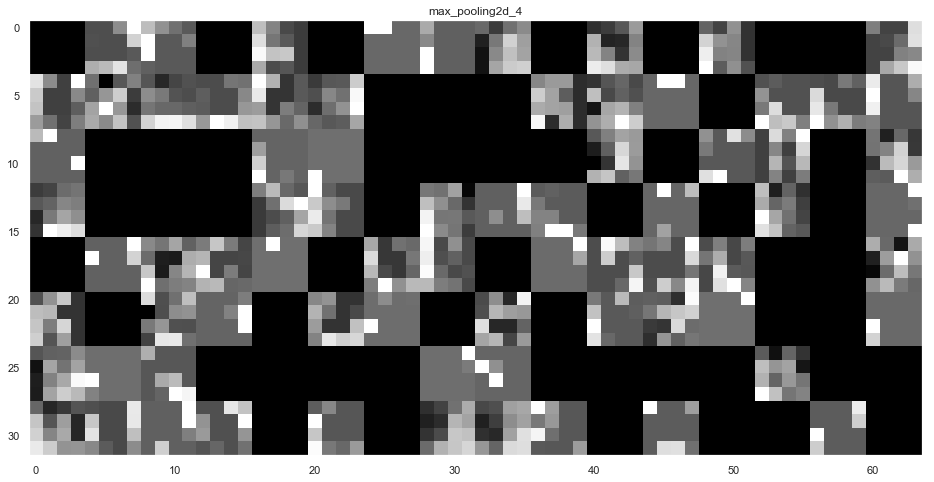

In [123]:
# let's try this again but with a cat image
img_path = os.path.join(train_path, 'cat.1.jpg')
viz_intermediate_activations(img_path, 8)

# Results

In [29]:
# didn't have time to do this
# refit models using a smaller number of epochs
def cnn_model_evaluation(num_epochs, model, model_name):
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    history = model.fit(X_train, y_train, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val, y_val), verbose=0)
    model.save(str(model_name+'.h5'))
    results = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    return results, predictions

## data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,)

def cnn_model_evaluation_with_dataug(num_epochs, model, model_name):
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    datagen.fit(X_train)
    history = model.fit(X_train, y_train, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val, y_val), verbose=0)
    model.save(str(model_name+'.h5'))
    results = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    return results, predictions

In [30]:
def dnn_model_evaluation(num_epochs, nodes1, nodes2):
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = dense_model_double(nodes1,nodes2)
    history = model.fit(X_train_dense, y_train, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val_dense, y_val), verbose=0)
    results = model.evaluate(X_test_dense, y_test)
    predictions = model.predict(X_test_dense)
    return results, predictions, model

In [39]:
# keeping epochs at 50 for consistency although could lessen this
dnn_300_300 = dnn_model_evaluation(50, 300, 300)

1000/1000 [==============================] - 0s 291us/step


In [37]:
# run these models on the test set
cnn_4_pyramid = load_model('CNN 4 Layers.h5')
cnn_4_pyramid_results = cnn_4_pyramid.evaluate(X_test, y_test)
cnn_4_pyramid_predictions = cnn_4_pyramid.predict(X_test)

cnn_4_64 = load_model('CNN 4 Layers - V6.h5')
cnn_4_64_results = cnn_4_64.evaluate(X_test, y_test)
cnn_4_64_predictions = cnn_4_64.predict(X_test)

cnn_4_data_aug = load_model('CNN 4 Layers - V6.h5')
cnn_4_data_aug_results = cnn_4_data_aug.evaluate(X_test, y_test)
cnn_4_data_aug_predictions = cnn_4_data_aug.predict(X_test)

1000/1000 [==============================] - 9s 9ms/step


In [49]:
# generate table to summarize results
dnn_acc = '{:.1%}'.format(dnn_300_300[0][1])
cnn_m1_acc = '{:.1%}'.format(cnn_4_pyramid_results[1])
cnn_m2_acc = '{:.1%}'.format(cnn_4_64_results[1])
cnn_m3_acc = '{:.1%}'.format(cnn_4_data_aug_results[1])

a = PrettyTable()
a.field_names = ['Model', 'Nodes', 'Accuracy']
a.add_row(['DNN', '300,300', dnn_acc])
a.add_row(['CNN - Pyramid', '32,64,128,128', cnn_m1_acc])
a.add_row(['CNN - Flat','64,64,64,64', cnn_m2_acc])
a.add_row(['CNN - Data Aug', '32,64,128,128', cnn_m3_acc])
print(a.get_string(title="Test Set Results"))

+-------------------------------------------+
|              Test Set Results             |
+----------------+---------------+----------+
|     Model      |     Nodes     | Accuracy |
+----------------+---------------+----------+
|      DNN       |    300,300    |  59.1%   |
| CNN - Pyramid  | 32,64,128,128 |  75.8%   |
|   CNN - Flat   |  64,64,64,64  |  76.9%   |
| CNN - Data Aug | 32,64,128,128 |  76.9%   |
+----------------+---------------+----------+


# Appendix

In [63]:
# because we don't have RGB images, we have to 'cheat' to be able to use pre-trained networks
X_train_stacked = np.stack((X_train,)*3, axis=-1)
X_train_stacked = np.squeeze(X_train_stacked, axis=3)
X_val_stacked = np.stack((X_val,)*3, axis=-1)
X_val_stacked = np.squeeze(X_val_stacked, axis=3)
X_test_stacked = np.stack((X_test,)*3, axis=-1)
X_test_stacked = np.squeeze(X_test_stacked, axis=3)

In [64]:
print(X_train_stacked.shape)
print(X_val_stacked.shape)
print(X_test_stacked.shape)

(3000, 96, 96, 3)
(1000, 96, 96, 3)
(1000, 96, 96, 3)


In [83]:
#https://github.com/keras-team/keras/issues/4465
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
input = Input(shape=(height,width,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(n_outputs, activation='sigmoid')(x)

#Create your own model 
my_model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("de...)`


In [ ]:
# need to add the compile step
my_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=.01), metrics=['accuracy'])

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 512

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(96,96),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(X_train_stacked, 3000)
validation_features, validation_labels = extract_features(X_val_stacked, 1000)
test_features, test_labels = extract_features(X_test_stacked, 1000)

In [66]:
def pretrained_cnn_generation(model, model_name):
    tf.set_random_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = model
    history = model.fit(X_train_stacked, y_train, batch_size=n_batch_size, epochs=num_epochs, validation_data = (X_val_stacked, y_val), verbose=0)
    model.save(str(model_name+'.h5'))
    summary = model.summary()
    weights = model.get_weights()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
    plt.figure(1)
    plt.subplot(121)
    loss_plot(history, model_name)
    plt.subplot(122)
    acc_plot(history, model_name)
    plt.show()
    return summary, weights, history